In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import plotly.express as px
import matplotlib.tri as tri
import xarray as xr
from scipy.interpolate import griddata
import numpy as np
import gsw
import string
import warnings
warnings.filterwarnings('ignore')
import matplotlib as mpl
import cmocean as cmo
from tqdm import tqdm
import cmcrameri 
import os
import sys

# Set the path for the src directory
sys.path.append(os.path.abspath(os.path.join('..', 'src')))
from bathymetry_along_fjord import df_bath
from paths import f75, f300
from velocity_preprocessing_functions import open_and_proces_mat_adcp




In [2]:

from plot_transect import  plot_individual_transect, plot_transect_from_big_file, df_all



give plotting variables per variable
and 
## grid data with interval

In [3]:
def colors(var, nrows=3):
    alphabet = list(string.ascii_lowercase)
    alphabet = alphabet + [i+j for i in alphabet for j in alphabet]
    if (var == 'CT' ) or (var=='Potential temperature [°C]'):
        levels = np.arange(0,3.5,0.2)
        subplot_letter = alphabet[:nrows]
        colorscale = "cmo.thermal"
        clabel= "Conservative Temperature [°C]"

    elif (var == 'SA') or (var=="Salinity [PSU]"):
        levels = np.arange(33.2,33.7,0.025)
    
        subplot_letter = alphabet[nrows:nrows*2]
        colorscale = "cmo.haline"
        clabel= "Salinity [g/kg]"
    return levels, subplot_letter, colorscale, clabel

def grid_data(x, y, z, interval_x=1, interval_y=1, interpolate=False):
    if interpolate:
        # define grid.
        offset_x = ((max(x)-min(x))%1)/2  # to make sure the grid is centered
        xi = np.arange(min(x)+offset_x, max(x), interval_x)
        yi = np.arange(min(y), max(y), interval_y)
        # grid the data.
        zi = griddata((x, y), z, (xi[None,:], yi[:,None]), method='linear')
    else:
        xi = x.sort_values().unique()
        yi = y.sort_values().unique()
        zi = griddata((x, y), z, (xi[None,:], yi[:,None]), method='linear')
    return xi, yi, zi

def mm2inch(value):
    return value/25.4  # centimeters in inches

def fmt_label(x):
    s = f"{x:.1f}"
    if s.endswith(".0"):
        s = f"{x:.0f}"
    return rf"{s}" if plt.rcParams["text.usetex"] else f"{s}"

# Specific functions for plotting
## Extract transect
## Add secondary axis
## Plot station triangles
## bathymetry_line

In [4]:
def extract_transect(df):
    '''
    takes df with all stations and returns a dataframe with only one row per station
    handy to make plots
    reurns data frame
    '''
    df_transect = pd.DataFrame()
    for name in df.Name.unique():
        row = (df[df.Name == name].iloc[0,:])
        # add row to a data frame
        df_transect = pd.concat([df_transect, row], axis=1)

    return df_transect.T.set_index('Name',drop=True).sort_values(['Distance'])

def add_secondary_axis(ax, xticks, xticklabels):
    secax = ax.secondary_xaxis('top')
    secax.set_xlabel("")
    secax.set_xticks(xticks)
    secax.set_xticklabels(xticklabels, rotation=0, fontsize=8)
    secax.title.set_position([0.1,1])
    return secax


def plot_stations(df, ax, depth=100, text=True, text_offset=5, max_distance=None, s=100):
    '''
    plot station locations on transect plot with triangles
    takes df used
    ax = ax in subplot
    depth = depth at which to plot the stations
    text = True if you want to annotate the stations
    text_offset = offset of the text depth in order to not overlap 
    max_distance = dont plot station outside this range
    '''
    df_transect = extract_transect(df)
    if max_distance:
        df_transect = df_transect[df_transect.Distance <= max_distance]
    ax.scatter(df_transect.Distance, np.repeat(depth, len(df_transect)), marker='v', color='k', edgecolors='white', s=s, zorder=10, linewidths=2)
    # annotate the stations
    if text:
        for i, txt in enumerate(df_transect['St.']):
            ax.annotate(txt, (df_transect.Distance[i], depth+text_offset), rotation=0, fontsize=10,  annotation_clip=False, ha='center', va='bottom')
    return df_transect.Distance.values, df_transect['St.'].values

def bathymetry_line(ax, df_bath):
    '''Add bathymetry to matplotlib plo
    ax = ax in subplot
    df_bath = bathymetry data frame'''
    ## bathymetry
    ax.plot(df_bath["Distance [km]"],df_bath.Depth, color='k', linewidth=1, alpha=0.5, zorder=15)
    ax.fill_between(df_bath["Distance [km]"],np.repeat(-650, len(df_bath)), df_bath.Depth, color='white', linewidth=1,  alpha=1, zorder=14) # adding bathymetry

## Import velocity vectors

Number of samples:  9266
Number of bins:  40
Bin size: 16 m
Number of observations per day: 24.0
first ping:  2018-05-27 13:00:00
last ping:  2019-06-17 13:59:59
sampling interval: 59.98 minutes
Mounting depth: 532
Number of bins after removing above water surface: 40
Removing approx to 10 percent, or upper bins based on inspections: 2 bins
Final number of bins:  30
Shallowest bin:  507.3 m

 Rotating velocities
Using PCA to rotate velocities
Components [[ 0.85241584  0.52286445]
 [ 0.52286445 -0.85241584]]
Explained Variance [3029.35308202 1267.86551065]
Degrees of components 32, -58
Mean of X_pca [ 8.  -1.7]
Mean of X [5.9 5.7]
Mean of Magnitude of X 55.42 mm/s
Mean of Magnitude of X_pca 55.42 mm/s



 Calculating tides and removing them
Along
Std of original data:  41.16
Std of prediction: 38.74
Across
Std of original data:  17.58
Std of prediction: 4.90
Variance of original data: 1694.88
Variance of prediction: 1501.02
Variance of prediction as percentage of original data: 88.56%
N

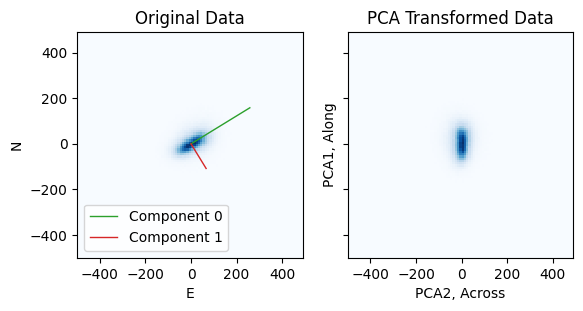

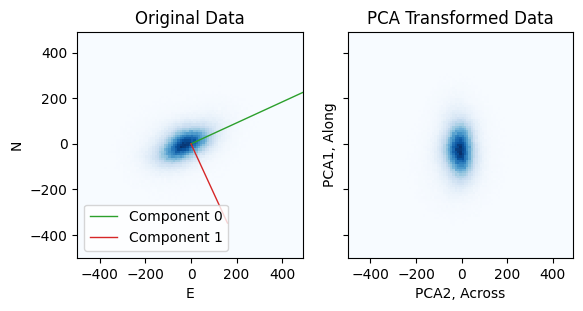

In [8]:

def import_velocity_data(Hz="75", St="GF10"):
    '''
    import velocity data from a netcdf file
    returns a data set
    '''
    if (St == "GF10") & (Hz == "75"):
        ds_velo, _, df_cons75, _, _, _, _, _, _, ds_velo_no_outlier_removal_75 = open_and_proces_mat_adcp(f75)
    elif (St == "GF10") & (Hz == "300"):
        ds_velo, _, df_cons300, _, _, _, _, _, _, ds_velo_no_outlier_removal_300 = open_and_proces_mat_adcp(f300)
    return ds_velo

ds_velo_75 = import_velocity_data(Hz="75", St="GF10")
ds_velo_300 = import_velocity_data(Hz="300", St="GF10")

def add_velocity_vectors(ax, date, n =2, width=1.0, velocity_day=1, Hz=75, nmeters=1):
    ''' Adding daily mean velocity vectors, currently only for 75khz at GF10
    n = plot every nth vector
    nmeters= ever n meters, only use when using both 75 and 300 khz, step size determined by ceil(nmeters/binsize)'''
    #resample per day and choose date from dates_spring_inflow
    if Hz == 75:
        velo_select = ds_velo_75.resample(time='1D').mean()
    elif Hz == 300:
        velo_select = ds_velo_300.resample(time='1D').mean()
    else:
        n= 1
        velo_select = xr.merge([ds_velo_75.resample(time='1D').mean().sel(z=slice(None, None, int(np.ceil(nmeters/16)))), ds_velo_300.resample(time='1D').mean().sel(z=slice(None, None, int(np.ceil(nmeters/2))))])

    if velocity_day == 1:
        velo_select=velo_select.sel(time=date, z=slice(None, None, n))
    else:
        bandwidth_days = np.floor(velocity_day/2)
        velo_select=velo_select.sel(time=slice(pd.to_datetime(date)-pd.to_timedelta(bandwidth_days,'days'), pd.to_datetime(date)+pd.to_timedelta(bandwidth_days,'days')), z=slice(None, None, n)).mean(dim='time')
    return ax.quiver(np.repeat(94, len(velo_select.z)), velo_select.z*-1, velo_select.Alongmmpersec, 0,width=width, linewidth=0.3, edgecolor='white', scale = 600)



## color bar

In [7]:
lon= -51.18810619555545
lat = 64.47646334793227
mean_sal = 33.234548899892154
mean_pres = 239.38910736127735

# i checked for sensititivity of the conversion to the mean pressure and salinity but it is very small in these ranges

def SAtoPS(x):
    '''Converts Absolute Salinity to Practical Salinity'''
    return gsw.SP_from_SA(x, mean_pres,  lon=lon,lat=lat)
def PStoSA(x):
    '''Converts Practical Salinity to Absolute Salinity'''
    return gsw.SA_from_SP(x, mean_pres, lon=lon,lat=lat)
def CTtoPT(x):
    '''Converts Conservative Temperature to Potential Temperature'''
    return gsw.pt_from_CT(mean_sal, x)
def PTtoCT(x):
    '''Converts Potential Temperature to Conservative Temperature'''
    return gsw.CT_from_pt(mean_sal, x)

In [8]:
def add_top_colorbars(fig, cCT, cSA, y_pos=0.95, y_height=0.03, second_cbar_ax=False, templabel=r"CT [$^\circ$C]", sallabel='SA [g/kg]'):
    '''
    add colorbars to the top of the figure with two columns of subplots
    y_pos = position of the colorbar relative to the figure
    y_height = height of the colorbar relative to the figure
    '''
    # colorbars
    # Create axes for colorbars
    cbar_ax1 = plt.axes([0.13, y_pos, 0.35, y_height])
    cbar_ax2 = plt.axes([0.54, y_pos,  0.35, y_height])
    # Create colorbars for each subplot
    cbar_CT = fig.colorbar(cCT, cax=cbar_ax1, orientation='horizontal')
    cbar_SA = fig.colorbar(cSA, cax=cbar_ax2, orientation='horizontal')
    # only show every second label on cbar_SA
    # cbar_SA.set_ticks(cbar_SA.get_ticks()[::2])
    cbar_ax1.tick_params(size=0)
    cbar_ax2.tick_params(size=0)
    # add cbar labels
    cbar_CT.set_label(templabel)
    cbar_SA.set_label(sallabel)
    for cbarax in [cbar_ax1, cbar_ax2]:
        cbarax.xaxis.set_ticks_position('bottom')
        cbarax.xaxis.set_label_position('bottom')
        cbarax.tick_params(labelsize=10)

    if second_cbar_ax:
        ticks = cbar_CT.get_ticks()
        ticks2 = CTtoPT(ticks).round(1)
        pos = cbar_ax1.get_position()
        cbar_ax1.set_aspect('auto')
        ax2_CT = cbar_ax1.twiny()
        ax2_CT.set_xlim([min(ticks2), max(ticks2)])
        ax2_CT.set_xticks(ticks2)
        ax2_CT.set_position(pos)
        ax2_CT.set_xlabel('PT [$^\circ$C]')

        ticks = cbar_SA.get_ticks()
        ticks2 = SAtoPS(ticks).round(2)
        pos = cbar_ax2.get_position()
        cbar_ax2.set_aspect('auto')
        ax2_SA = cbar_ax2.twiny()
        ax2_SA.set_xlim([min(ticks2), max(ticks2)])
        ax2_SA.set_xticks(ticks2)
        ax2_SA.set_position(pos)
        ax2_SA.set_xlabel('PSU')
        for ax in [ax2_CT, ax2_SA]: ax.tick_params(size=0)


def add_colorbar_john(fig, cCT, cSA, y_pos=0.95, y_height=0.03, second_cbar_ax=False, templabel=r"$\theta$ [$^\circ$C]", sallabel='Salinity', Tticks = None):
    # recttuple (left, bottom, width, height)
    cbar_ax1 = fig.add_axes([0.13, y_pos, 0.35, y_height])
    cbar_ax2 = fig.add_axes([0.54, y_pos,  0.35, y_height])

    # Create colorbars for each subplot
    cbar_CT = fig.colorbar(cCT, cax=cbar_ax1, orientation='horizontal', extend= None, spacing='uniform')
    cbar_SA = fig.colorbar(cSA, cax=cbar_ax2, orientation='horizontal',extend= None, spacing='uniform')
    # only show every second label on cbar_SA
    # cbar_SA.set_ticks(cbar_SA.get_ticks()[::2])
    if Tticks is not None:
        cbar_CT.set_ticks(Tticks)
    cbar_ax1.tick_params(size=0)
    cbar_ax2.tick_params(size=0)
    # add cbar labels
    cbar_CT.set_label(templabel)
    cbar_SA.set_label(sallabel)
    for cbarax in [cbar_ax1, cbar_ax2]:
        cbarax.xaxis.set_ticks_position('top')
        cbarax.xaxis.set_label_position('top')
        cbarax.tick_params(labelsize=10)
        cbarax.xaxis.set_major_formatter(lambda x, _: f'{x:g}')

In [50]:
df_Flo.columns

Index(['conductivity', 'T', 'P', 'chlorophyll-a', 'fdom', 'turbidity', 'Ps',
       'depth', 'S', 'speed_of_sound', 'specific_conductivity', 'SIGTH',
       'distance'],
      dtype='object')

In [58]:
df_Flo["T"]

2024-08-19 14:22:43.375    0.745758
2024-08-19 14:22:43.500    0.744843
2024-08-19 14:22:43.625    0.745972
2024-08-19 14:22:43.750    0.743652
2024-08-19 14:22:43.875    0.743988
                             ...   
2024-08-19 16:12:48.125    3.896027
2024-08-19 16:12:48.250    3.912262
2024-08-19 16:12:48.375    3.869904
2024-08-19 16:12:48.500    3.959351
2024-08-19 16:12:48.625    4.132446
Name: T, Length: 38701, dtype: float64

In [62]:
df_Flo.distance

2024-08-19 14:22:43.375        0
2024-08-19 14:22:43.500        0
2024-08-19 14:22:43.625        0
2024-08-19 14:22:43.750        0
2024-08-19 14:22:43.875        0
                           ...  
2024-08-19 16:12:48.125    17544
2024-08-19 16:12:48.250    17544
2024-08-19 16:12:48.375    17544
2024-08-19 16:12:48.500    17544
2024-08-19 16:12:48.625    17544
Name: distance, Length: 38701, dtype: int64

In [59]:
xi, yi, zi = grid_data(df_Flo.distance, df_Flo.depth, df_Flo["T"])

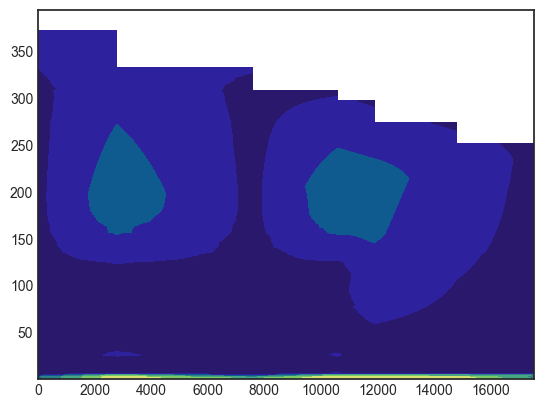

In [61]:
fig, ax = plt.subplots()
cfill = ax.contourf(xi, yi, zi, cmap=colorscale, extend='both')    # this is the plotiting of theo contour fill

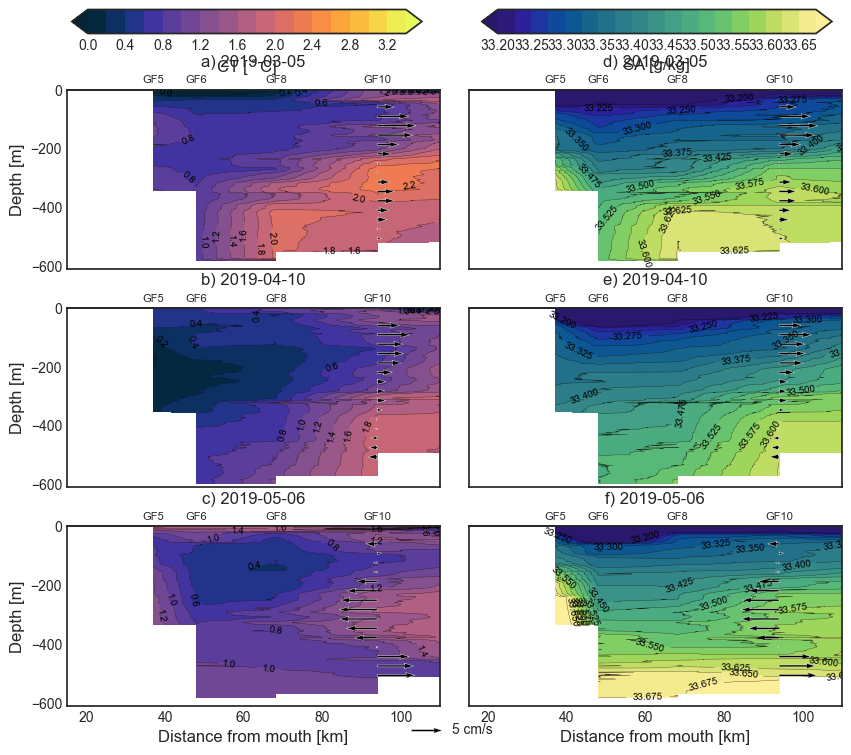

In [11]:
# suppress warnings
import warnings
warnings.filterwarnings('ignore')
# style sheet
plt.style.use('seaborn-white')
date_spring_inflow = ["2019-03-05", "2019-04-10", "2019-05-06"]
dates = date_spring_inflow

# Create subplots with 2 rows and 2 columns
fig, axs = plt.subplots(len(dates), 2, sharey=True, sharex=True, figsize=(10,8))



# Plot data on subplots
cfig = []
for i, contour_var in enumerate(['CT', 'SA']):
    for j, date in enumerate(dates):
        z_var ='Depth'
        fig1, df = plot_transect_from_big_file(date =date, variable_fill=contour_var)   # import df from file
        levels, subplot_letter, colorscale, clabel = colors(contour_var)
        xi, yi, zi = grid_data(df.Distance, df[z_var], df[contour_var], interval_x=5, interval_y=200) # grid data with interval of 5 km in x and 2 m in y
        cfill = axs[j, i].contourf(xi, yi, zi,  levels=levels, cmap=colorscale, extend='both')    # this is the plotiting of theo contour fill
        cline = axs[j, i].contour(xi, yi, zi,levels=levels, colors='k', linewidths=0.2) # add contour lines
        axs[j, i].clabel(cline, cline.levels, inline=True, fontsize=7) # add labels to contours
        # axs[j,i].fill_between(df_bath["Distance [km]"],np.repeat(-650, len(df_bath)), df_bath.Depth, color='white', linewidth=2, alpha=0.99, zorder=15) # adding bathymetry
        axs[j,i].set_title(f'{subplot_letter[j]}) {date}', fontsize=12)
        add_secondary_axis(axs[j,i], xticks=extract_transect(df).Distance.values.astype(float), xticklabels=extract_transect(df)['St.'].values.astype(str))
        q = add_velocity_vectors(axs[j,i], date, n=2, width=5e-3)
    if contour_var == 'CT':
        cCT = cfill
    elif contour_var == 'SA':
        cSA = cfill



add_top_colorbars(fig, cCT, cSA)

# Set axis labels
axs[-1, 0].set_xlabel('Distance from mouth [km]')
axs[-1, 1].set_xlabel('Distance from mouth [km]')

plt.quiverkey(q, X=0.5, Y=0.08, U=50,
             label='5 cm/s', labelpos='E', coordinates='figure')


# for all axes set minimum y range
for ax in axs.flat:
    ax.set_ylim([ -610, -0])
    ax.set_xlim([ 15, 110])
for i in range(np.shape(axs)[0]): axs[i, 0].set_ylabel('Depth [m]')


# Adjust spacing between subplots
plt.subplots_adjust(wspace=0.077, hspace=0.22)
# plt.savefig(f'{figpath}/CT_SA_transect.png', dpi=600, bbox_inches='tight')


In [10]:


# date_autumn_inflow = ["2018-09-06", "2018-10-15", "2018-10-31", "2018-12-11", "2019-02-05"]
# date_autumn_inflow_short = ["2018-10-15", "2018-10-31", "2018-12-11"]
# dates = date_autumn_inflow_short
# dates = ['2018-10-31', '2018-12-11', '2019-02-05',  '2019-03-05', '2019-04-10', '2019-05-06',]
# # Create subplots with 2 rows and 2 columns
# fig, axs = plt.subplots(len(dates), 2, sharey=True, sharex=True, figsize=(10,15))


# # Plot data on subplots
# cfig = []
# for i, contour_var in enumerate(['CT', 'SA']):
#     for j, date in enumerate(dates):
#         z_var ='Depth'
#         fig1, df = plot_transect_from_big_file(date =date, variable_fill=contour_var)   # import df from file
#         levels, subplot_letter, colorscale, clabel = colors(contour_var,nrows=len(dates))
#         xi, yi, zi = grid_data(df.Distance, df[z_var], df[contour_var], interval_x=1, interval_y=2) # grid data with interval of 5 km in x and 2 m in y
#         cfill = axs[j, i].contourf(xi, yi, zi,  levels=levels, cmap=colorscale, extend='both')    # this is the plotiting of theo contour fill
#         cline = axs[j, i].contour(xi, yi, zi,levels=levels[::2], colors='k', linewidths=0.2) # add contour lines
#         axs[j, i].clabel(cline, cline.levels[::2], inline=True, fontsize=7) # add labels to contours
#         axs[j,i].fill_between(df_bath["Distance [km]"],np.repeat(-650, len(df_bath)), df_bath.Depth, color='white', linewidth=2, alpha=0.99, zorder=15) # adding bathymetry
#         axs[j,i].set_title(f'{subplot_letter[j]}) {date}', fontsize=12)
#         add_secondary_axis(axs[j,i], xticks=extract_transect(df).Distance.values.astype(float), xticklabels=extract_transect(df)['St.'].values.astype(str))
#         # q = add_velocity_vectors(axs[j,i], date, n=1, width=5e-3)
#     if contour_var == 'CT':
#         cCT = cfill
#     elif contour_var == 'SA':
#         cSA = cfill

# add_top_colorbars(fig, cCT, cSA)  

# # Set axis labels
# axs[-1, 0].set_xlabel('Distance from mouth [km]')
# axs[-1, 1].set_xlabel('Distance from mouth [km]')

# # for all axes set minimum y range
# for ax in axs.flat:
#     ax.set_ylim([ -650, -0])
#     ax.set_xlim([ 15, 110])
# for i in range(np.shape(axs)[0]): axs[i, 0].set_ylabel('Depth [m]')

# plt.quiverkey(q, X=0.5, Y=0.08, U=50,
#              label='5 cm/s', labelpos='E', coordinates='figure')

# # Adjust spacing between subplots
# plt.subplots_adjust(wspace=0.08, hspace=0.22)
# # plt.savefig(f'{figpath}/lenght_transect/CT_SA_transect_winter.png', dpi=300, bbox_inches='tight')


# Plot all dates

In [12]:
dates = ['2018-06-06', '2018-06-11', '2018-06-27','2018-08-08', '2018-08-09',  '2018-09-06', '2018-10-15', '2018-10-31', 
         '2018-12-11',  '2019-02-05',  '2019-03-05', '2019-04-10', '2019-05-06','2019-06-04', '2019-07-01', ]

In [13]:
figpathjohn = "/Users/annek/Library/CloudStorage/OneDrive-SharedLibraries-NIOZ/PhD Anneke Vries - General/Figures/for john june 13"


In [14]:
# substract one day from '2018-06-06'
date = ['2018-06-05']
pd.to_datetime(date) - pd.Timedelta(days=1)

DatetimeIndex(['2018-06-04'], dtype='datetime64[ns]', freq=None)

In [15]:
# import matplotlib.pyplot as plt
# from mpl_toolkits.axes_grid1 import make_axes_locatable
# import numpy as np

# # Sample data
# data = np.random.random((5, 5)) * 100.0  # Create some random data

# # Create a plot
# fig, ax = plt.subplots()
# im = ax.imshow(data, cmap='viridis')

# # Create a divider for the existing axes instance
# divider = make_axes_locatable(ax)
# cax = divider.append_axes("right", size="5%", pad=0.1)  # Adjust the size and pad as needed

# # Create a horizontal colorbar
# cbar = plt.colorbar(im, cax=cax, orientation="horizontal")

# # Format the colorbar tick labels using a lambda function
# cbar.ax.xaxis.set_major_formatter(lambda x, _: f'{x:g}')

# # Add a label to the colorbar
# cbar.set_label("Colorbar Label", labelpad=10)  # Adjust the labelpad as needed

# # Show the plot
# plt.show()


In [20]:
def melt_line(T, S, Sarray, slope=2.94):
    '''Draw a line that goes through point T on the y-axis and S on the x-axis, with a default slope of 2.94, for all point sin Sarray'''
    b = T - slope*S
    return slope*Sarray + b

def mix_line(T, S,Sarray):
    ''' Draw a line through 0 salinity and 0 temperature and through point T and S'''
    slope = T/S
    b = 0
    return slope*Sarray + b

def plot_TS_diagram(df, ax, date, T='CT', S='SA', color='k', label=None, linestyle='-', linewidth=1):
    '''Plot a TS diagram for a given date, with default T and S being CT and SA'''
    df = df[df.Date == date]
    ax.scatter( df[S], df[T],  label=label, linestyle=linestyle, linewidth=linewidth)
    return ax


# draw a box of 33.5 to 33.6 and 0.5 to 1.5
def rectangle_corner_points(Smin, Smax, Tmin, Tmax):
    '''Draw a rectangle with corner points Smin, Smax, Tmin, Tmax'''
    return [[Smin, Tmin], [Smin, Tmax], [Smax, Tmax], [Smax, Tmin], [Smin, Tmin]]
# ax.plot(*np.array(rectangle_corner_points(33.5, 33.6, 0.5, 1.5)).T,  linewidth=1)
# 
def add_water_mass(ax):
    dfWaterMass = pd.read_excel( Path.cwd().joinpath("../intermediate_files/Water_masses_Mortensen_2011.xlsx")).rename(columns={ 'T (Potential Temperature)':'T',  'S (Practical Salinity)':'S'})
    ax.scatter(dfWaterMass['S'], dfWaterMass['T'], s=5, color='k', marker='x')
    for j, txt in enumerate(dfWaterMass.Abbreviation):
        ax.annotate(txt, (dfWaterMass['S'][j], dfWaterMass['T'][j]+0.2), ha='center', va='center')



# # alphabet
# import string
# alphabet = list(string.ascii_lowercase)
# for i, ax in enumerate(axs.flat):
#     print(i, ax)
#     ax.text(0.5, 0.5, f'ax {alphabet[i]}', fontsize=12, ha='center', va='center', transform= ax.transAxes)

# Profiles and transects

## Figure 4

In [ ]:
def mm2inch(value):
    return value / 25.4

def fmt_label(x):
    s = f"{x:.1f}"
    if s.endswith(".0"):
        s = f"{x:.0f}"
    return rf"{s}" if plt.rcParams["text.usetex"] else f"{s}"

In [1]:
dates = [['2018-10-31', '2018-12-11', '2019-03-05', '2019-04-10', '2019-05-06']]
phases = ['', '', '', '', '']

levels50 = [10, 20, 25, 30, 31, 32, 33]
maxz = 550
velocity_day = 3

alphabet = list(string.ascii_lowercase)
n = len(np.squeeze(dates))


plt.rcParams.update({'font.size': 9})
color_overview = plt.cm.viridis(len(dates))

unique_distances = np.sort(df_all['Distance'].unique())
min_distance = unique_distances[0]

for maxz in [550]:
    plot_height = 15 / 7.5
    nr_rows = len(dates[0])
    fig, axs = plt.subplots(nr_rows, 2, sharey=True, sharex=True, figsize=(mm2inch(190), mm2inch(230 / 1.5)))

    for i, contour_var in enumerate(['Potential temperature [°C]', 'Salinity [PSU]']):
        for j, date in tqdm(enumerate(dates[0])):
            z_var = 'Depth'
            fig1, df = plot_transect_from_big_file(date=date, variable_fill=contour_var)
            xi, yi, zi = grid_data(df.Distance, df[z_var], df[contour_var], interval_x=5, interval_y=2)
            if contour_var == 'Potential temperature [°C]':
                colorscale = mpl.colors.ListedColormap(cmo.cm.thermal(np.linspace(0, 1, 15)))
                cmap = colorscale
                bounds = [-1.8, 0, 0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 2, 2.25, 2.5, 2.75, 3, 3.5, 10]
                norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
                levels_l = [-1.8, 0, 1, 2, 3, 3.5, 10]
                color_contourline = np.array(['black' if i > 0 else 'white' for i in levels_l])
                xlim_profile = [-0.5, 4] if maxz >= 200 else [-1.8, 3.3]
                xlim_profile_T = xlim_profile
            else:
                colorscale = mpl.colors.ListedColormap(cmo.cm.haline(np.linspace(0, 1, 6)))
                cmap = colorscale
                bounds = [7.5, 30.5, 32.8, 33.2, 33.4, 33.5, 33.7]
                norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
                levels_l = np.sort(np.concatenate([np.arange(30, 33, 1), np.arange(33, 33.56, 0.1), np.arange(33.6, 35.1, 0.4)]))
                xlim_profile = [32.9, 33.65] if maxz >= 200 else [30, 33.8]
                color_contourline = np.array(['black' if i >= 30.5 else 'white' for i in levels_l])
                xlim_profile_S = xlim_profile
                short_label = 'Salinity'
            levels = bounds

            cfill = axs[j, i].contourf(xi, yi, zi, levels=bounds, cmap=colorscale, extend=None, norm=norm, alpha=0.9)
            cline = axs[j, i].contour(xi, yi, zi, levels=levels_l, colors=color_contourline, linewidths=0.5)
            axs[j, i].clabel(cline, cline.levels, inline=True, fontsize=7, zorder=16, fmt=fmt_label)
            plot_stations(df, axs[j, i], depth=0, text=False, s=50)
            bathymetry_line(axs[j, i], df_bath)
            q = add_velocity_vectors(axs[j, i], pd.to_datetime(date) - pd.Timedelta(days=1), n=2, width=6e-3, velocity_day=velocity_day, Hz='both', nmeters=4.0 if maxz >= 200 else 2.0)
            textcol = 'black' if maxz >= 200 else 'white'

            ylabel = r"$\bf{" + str(phases[j]) + " " + pd.to_datetime(date).strftime('%b') + "}$ " + '\n' + 'Depth [m]'
            axs[j, i].set_ylabel(ylabel)

        if contour_var == 'Potential temperature [°C]':
            cCT = cfill
        elif contour_var == 'Salinity [PSU]':
            cSA = cfill

    for i, ax in enumerate(axs.flat):
        ax.text(0.05, 0.1, f'{alphabet[i]}', fontsize=10, color=textcol, transform=ax.transAxes, fontweight='bold', zorder=150)

    add_colorbar_john(fig, cCT, cSA, second_cbar_ax=False, y_pos=0.9, y_height=0.010, templabel=r"$\theta$ [$^\circ$C]", sallabel='S ', Tticks=[-1.8, 0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 10])
    axs[-1, 0].set_xlabel('Distance from mouth [km]')
    axs[-1, 1].set_xlabel('Distance from mouth [km]')
    for ax in axs.flat:
        ax.set_ylim([-maxz, -0])
        ax.set_xlim([35, 135])
        ax.tick_params(axis='both', which='major', length=3)
    for i in range(np.shape(axs)[0]):
        axs[i, 1].set_ylabel('')
    fig.subplots_adjust(wspace=0.06, hspace=0.13)
    axs[-1, 0].quiverkey(q, X=0.5, Y=0.07, U=30, label='3 cm/s', labelpos='E', coordinates='figure')

    fig.savefig(f'{figpath}/lenght_transect/CT_SA_transect_{n}_dates_{maxz}_velocity_every_{velocity_day}_day.jpg', dpi=300, bbox_inches='tight')
    fig.savefig(f'{figpath}/lenght_transect/CT_SA_transect_{n}_dates_{maxz}_velocity_every_{velocity_day}_day_draft.jpg', dpi=150, bbox_inches='tight')

    plt.show()


OSError: 'seaborn-ticks' is not a valid package style, path of style file, URL of style file, or library style name (library styles are listed in `style.available`)

In [16]:
def draw_arrow(ax, x, y, x_length, y_length, color='red', lw=2):
    """
    Draws an arrow on a given Matplotlib axes (ax) with the arrow pointing to (x, y),
    starting from (x - x_length, y - y_length).
    
    Parameters:
    - ax: Matplotlib axes object where the arrow will be drawn.
    - x, y: Ending coordinates (head) of the arrow.
    - x_length, y_length: Lengths of the arrow back from the head in x and y directions.
    - color: Color of the arrow (default is 'red').
    - lw: Line width of the arrow (default is 2).
    """
    # Calculate the start point based on the end point and lengths
    start_x = x - x_length
    start_y = y - y_length
    
    ax.annotate(
        '', 
        xy=(x, y),          # End point (head of the arrow)
        xytext=(start_x, start_y),  # Start point (tail of the arrow)
        arrowprops=dict(arrowstyle="->", color=color, lw=lw)
    )





In [19]:
df['Date'].unique()

array(['2019-05-06'], dtype=object)

## profiles

# Figure S1 
## Summer subglacial

0it [00:00, ?it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
1it [00:00,  2.04it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with la

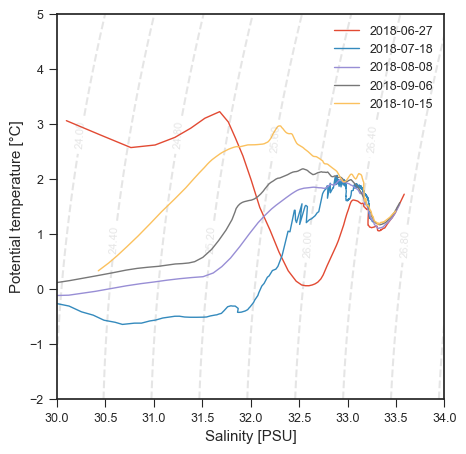

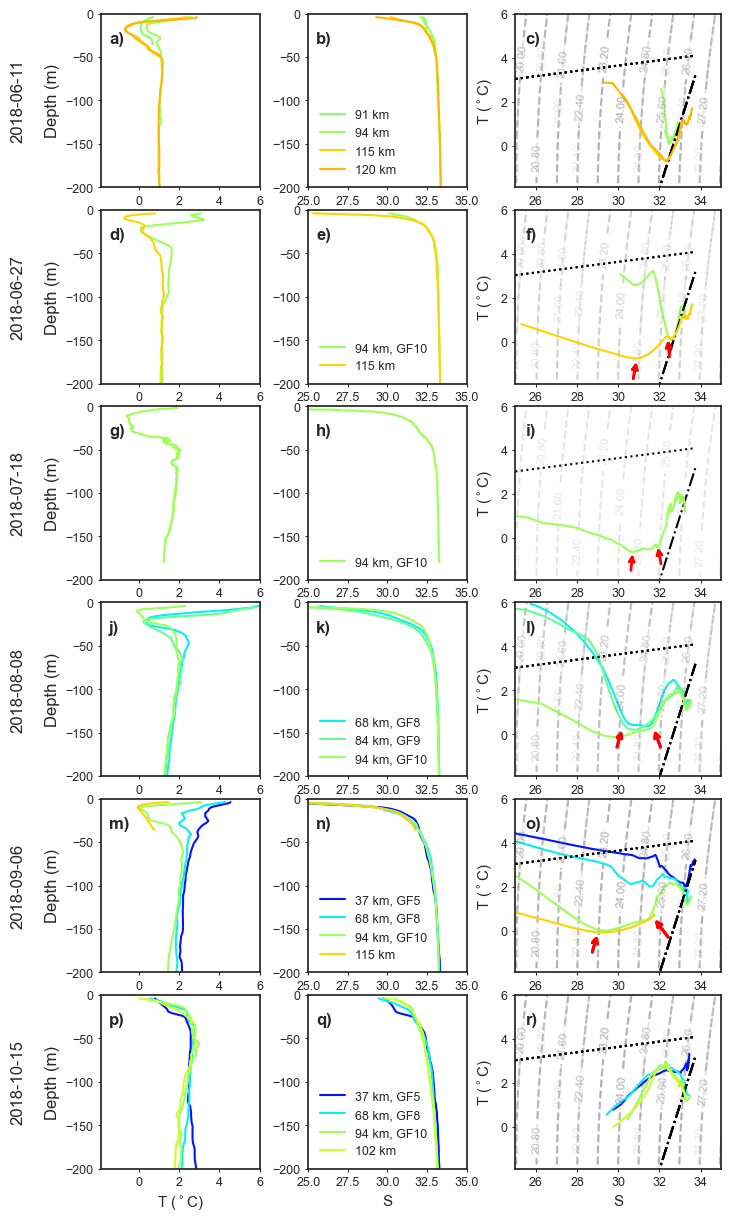

In [25]:
plt.style.use('seaborn-ticks')
from matplotlib.lines import Line2D


# name  = 'every_phase'
# dates = [['2018-05-04', '2018-06-06',  '2018-09-06',  '2018-10-31', '2018-12-11',  '2019-03-05',  '2019-04-10', '2019-05-06',]]
# phases = ['I/II', 'II', 'III', 'IV', 'V',  'VI', 'VI', 'I']
# 
phases = ['', '', '', '', '',  '', '', '', '', '', '']
# dates = [[ '2018-12-11',  '2019-03-05',  '2019-04-10', '2019-05-06',]]
name = "summer_subglacial_with_arrow"
dates = [[ '2018-06-11', '2018-06-27', '2018-07-18' , '2018-08-08',  '2018-09-06', '2018-10-15']]

# name = 'winter_intermediate'
# dates = [[ '2018-12-11',  '2019-02-05',  '2019-03-05', '2019-04-10', '2019-05-06',]]
# rangeS, rangeT = [32,34], [-.5, 4]

velocity_day = 3
plt.rcParams.update({'font.size': 9})

figTS_overview, axTSover= plt.subplots(1, 1, figsize=[5,5])
axTSover.set_xlabel('Salinity [PSU]')
axTSover.set_ylabel('Potential temperature [°C]')

cmap_profile = plt.cm.jet
unique_distances = np.sort(df_all['Distance'].unique())

rangeT = [-1.9, 6]
rangeS = [25,35]

WP_melt = dict(T=2, S=33.2)

WP_melt = dict(T=1, S=33)
WP_mix =  dict(T=4, S=33)

TSdiagram(axTSover, np.linspace(25, 35, 100), Tvals=np.linspace(-2,5, 100), levels=20, alpha=0.2)




def make_label_name(station_name, distance):
    if str(station_name) == 'nan':
        label_name = f"{distance:.0f} km"
    elif station_name == 'IE':
        station_name = 'Ice edge'
        label_name = f"{distance:.0f} km, {station_name}"
    else:
        label_name = f"{distance:.0f} km, {station_name}"
    return label_name

# def add_arrow(ax, x, y, x_length, y_length, color='red'):
#     ax.annotate('', xy=(x, y), xytext=(x + x_length, y + y_length), textcoords='offset points', arrowprops=dict(facecolor=color, edgecolor=color, arrowstyle='->', linewidth=2))

for maxz in [200]:
    plot_height = 2.5
    nr_rows = len(dates[0])

    fig_profile, axs_profile = plt.subplots(nr_rows, 3, sharey=False, sharex=False, figsize=(8,nr_rows*plot_height), gridspec_kw={'width_ratios': [1, 1, 1.3]})
    
    for i, contour_var in enumerate(['Potential temperature [°C]','Salinity [PSU]',]):
        for j, date in tqdm(enumerate(dates[0])):
            z_var ='Depth'
            fig1, df = plot_transect_from_big_file(date =date, variable_fill=contour_var)   # import df from file
            # xi, yi, zi = grid_data(df.Distance, df[z_var], df[contour_var], interval_x=5, interval_y=2) # grid data with interval of 5 km in x and 2 m in y
            axTS = axs_profile[j,2]

    
            for d in df.Distance.sort_values().unique():
                if min(abs(np.array([37,68,94,118, 110])-d)) > 8 and len(df.Distance.sort_values().unique()) >3 : continue
                dfst = df[df.Distance == d].sort_values('Depth')[:-1]
                dfst = dfst.sort_values(z_var)

                color = cmap_profile((d-unique_distances[0])/ (unique_distances[-1]-unique_distances[0]))  # Assign color based on Distance
                label_name = make_label_name(dfst['St.'].values[0], d)
                axs_profile[j,i].plot(dfst[contour_var].rolling(window=5, center=True).mean(), dfst[z_var], label = label_name, color=color)
                axs_profile[j,i].set_xlim(rangeS)
                legendS = axs_profile[j,1].legend()


                # TS diagram
                if contour_var == 'Potential temperature [°C]': 
                    axs_profile[j,i].set_xlim(rangeT)

                    TSdiagram(axTS, np.linspace(rangeS[0]*0.9, rangeS[1]*1.1, 100), Tvals=np.linspace(rangeT[0]*0.9, rangeT[1]*1.1, 100), levels=20, alpha=0.2)
                    # do a rolling average of dst
                    dfstROL = dfst.rolling(window=5, center=True).mean()
                    if maxz <=200:
                        axTS.plot(np.linspace(rangeS[0], 33.75, 100), melt_line(T=WP_melt["T"], S=WP_melt["S"], Sarray=np.linspace(rangeS[0], 33.75, 100)), color='black',  linestyle='-.')
                        axTS.plot(np.linspace(rangeS[0], 33.75, 100), mix_line(T=WP_mix["T"], S=WP_mix['S'], Sarray=np.linspace(rangeS[0], 33.75, 100)), color='black',  linestyle=":")
                    # axTS.scatter(dfst['Salinity [PSU]'],dfst[contour_var],label = f"{d:.0f} km, {dfst['St.'].values[0]}", color=color, s=1)
                    axTS.plot(dfstROL['Salinity [PSU]'],dfstROL[contour_var],label = f"{d:.0f} km, {dfst['St.'].values[0]}", color=color,)
                    # legendTS = axTS.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., fontsize=8)
                    # for handle in legendTS.legendHandles:
                    #     handle.set_sizes([30])
                    # scatter for depth is 100                       
                        

                    # add_depth_marker(dfst, 10, axTS, 's', color)
                    # add_depth_marker(dfst, 30, axTS, 'o', color)
                    # add_depth_marker(dfst, 80, axTS, 'd', color)

                    # add_water_mass(axTS)
                    axTS.set_ylim(rangeT)
                    axTS.set_xlim(rangeS)
                    axTS.tick_params(axis='both', which='major', length=2)
                    if 'GF10' in dfst['St.'].to_list():
                        # arange dfst by z_var

                        # axTSover.plot(dfst['Salinity [PSU]'],dfst['Potential temperature [°C]'], linewidth=.5, label=date)
                        axTSover.plot(dfstROL['Salinity [PSU]'],dfstROL['Potential temperature [°C]'], linewidth=1, label=date)

                    # elif 'GF5' in dfst['St.'].to_list():
                    #     axTSover.plot(dfst['Salinity [PSU]'],dfst['Potential temperature [°C]'], linewidth=0.5, linestyle='dashed', label=date)
 
                    if date == '2018-06-27':
                        draw_arrow(axTS, 30.9, -0.8, 0.2, 1, color='red')
                        draw_arrow(axTS, 32.4, 0.2, -0.1, 1, color='red')

                    if date == '2018-07-18':
                        draw_arrow(axTS, 30.7, -0.6, 0.1, 1, color='red')
                        draw_arrow(axTS, 31.9, -0.3, -0.2, 1, color='red')
                    if date == '2018-08-08':
                        draw_arrow(axTS, 30.2, 0.3, 0.3, 1, color='red')
                        draw_arrow(axTS, 31.7, 0.3, -0.4, 1, color='red')
                    if date == '2018-09-06':
                        draw_arrow(axTS, 29, -0.1, 0.3, 1, color='red')
                        draw_arrow(axTS, 31.7, 0.6, -0.8, 1, color='red')



            axs_profile[j,i].tick_params(axis='both', which='major', length=2)
            axs_profile[j,i].set_ylim([-maxz, 0])
            if phases[0] == '':
                ylabel = f'{date}'+'\n'+'\n'+ 'Depth (m)'
            else:
                ylabel = f'Phase {phases[j]}' +'\n'+ f'{date}'+'\n'+'\n'+ f'Depth (m)'
            axs_profile[j,0].set_ylabel(ylabel, fontsize=12)
            axs_profile[j,2].set_ylabel('T ($^\circ$C)')


            # # add box with corners 33.5, 33.4 and 0.5, 1.5
            # axTS.plot(*np.array(rectangle_corner_points(33.4, 33.6, 0.5, 1.5)).T,  linewidth=1)

    for i, ax_prof in enumerate(axs_profile.flat):
        ax_prof.text(0.05, 0.9,  f'{string.ascii_lowercase[i]})', transform=ax_prof.transAxes, fontsize=12, fontweight='bold', va='top')

    fig_profile.subplots_adjust(wspace=0.28, hspace=0.13)
    axTSover.legend()
    axTSover.set_xlim(30, 34)
    # plt.show()

axs_profile[-1,0].set_xlabel('T ($^\circ$C)')
axs_profile[-1,1].set_xlabel('S')
axs_profile[-1,2].set_xlabel('S')


# savefig
fig_profile.savefig(f'{figpath}/CTD profiles/FigureS1_CTD_profiles_{name}_{maxz}m.jpg', dpi=300, bbox_inches='tight')
figTS_overview.savefig(f'{figpath}/TS diagram/TS_diagram_{name}_{maxz}m.jpg', dpi=300, bbox_inches='tight')

# Figure S4: 
## CTD profiles winter strong circulation

0it [00:00, ?it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
1it [00:00,  4.26it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with la

/Users/annek/Library/CloudStorage/OneDrive-SharedLibraries-NIOZ/PhD Anneke Vries - General/Figures/CTD profiles/CTD_profiles_winter_intermediate_600m.jpg


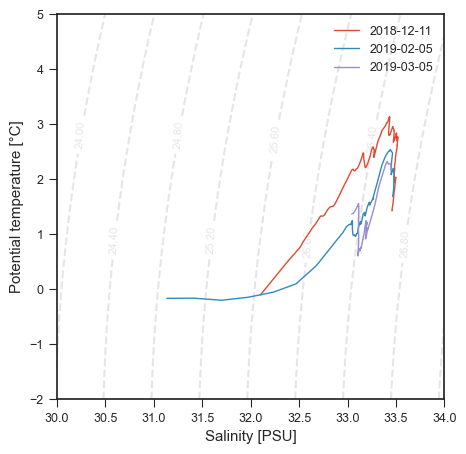

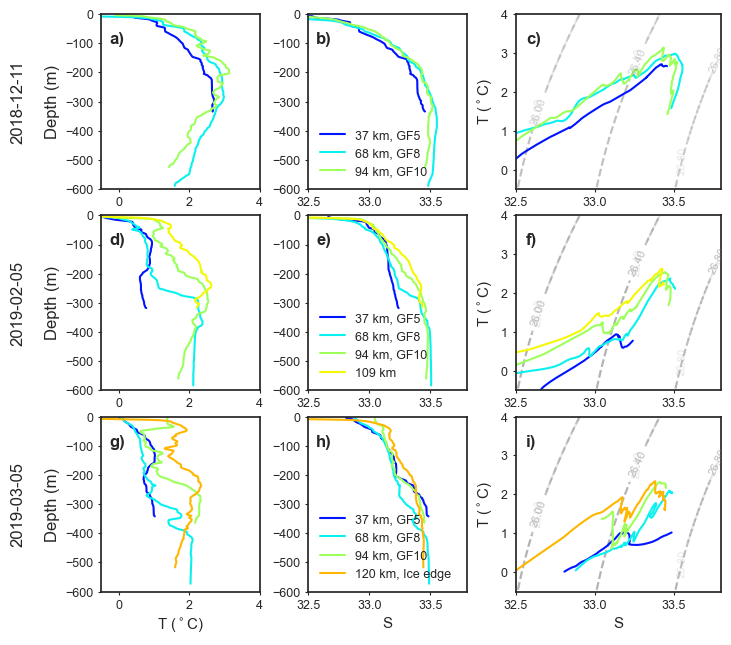

In [26]:
plt.style.use('seaborn-ticks')
from matplotlib.lines import Line2D

phases = ['', '', '', '', '',  '', '', '', '', '', '']



name = 'winter_intermediate'
dates = [[ '2018-12-11',  '2019-02-05',  '2019-03-05']]
rangeS, rangeT = [32.5,33.8], [-.5, 4]

velocity_day = 3
plt.rcParams.update({'font.size': 9})

figTS_overview, axTSover= plt.subplots(1, 1, figsize=[5,5])
axTSover.set_xlabel('Salinity [PSU]')
axTSover.set_ylabel('Potential temperature [°C]')

cmap_profile = plt.cm.jet
unique_distances = np.sort(df_all['Distance'].unique())



WP_melt = dict(T=2, S=33.2)

WP_melt = dict(T=1, S=33)
WP_mix =  dict(T=4, S=33)

TSdiagram(axTSover, np.linspace(25, 35, 100), Tvals=np.linspace(-2,5, 100), levels=20, alpha=0.2)


def add_depth_marker(dfst, point_depth, ax, marker, color):
    df_point_depth = dfst[dfst['Pressure'] == point_depth]
    ax.scatter(df_point_depth['Salinity [PSU]'], df_point_depth['Potential temperature [°C]'], s=20, edgecolors='black', facecolors=color, marker=marker, zorder=10)
    
    # Create a custom legend handle for the marker
    custom_marker = Line2D([0], [0], marker=marker, color='w', markerfacecolor='none', markeredgecolor='black', markersize=5, label=f'Depth: {point_depth}m')
    
    # Get existing handles and labels
    handles, labels = ax.get_legend_handles_labels()
    
    # Append the custom marker to the handles and labels
    handles.append(custom_marker)
    labels.append(f'Depth: {point_depth}m')
    
    # Update the legend
    ax.legend()

def make_label_name(station_name, distance):
    if str(station_name) == 'nan':
        label_name = f"{distance:.0f} km"
    elif station_name == 'IE':
        station_name = 'Ice edge'
        label_name = f"{distance:.0f} km, {station_name}"
    else:
        label_name = f"{distance:.0f} km, {station_name}"
    return label_name

# def add_arrow(ax, x, y, x_length, y_length, color='red'):
#     ax.annotate('', xy=(x, y), xytext=(x + x_length, y + y_length), textcoords='offset points', arrowprops=dict(facecolor=color, edgecolor=color, arrowstyle='->', linewidth=2))

for maxz in [600]:
    plot_height = 2.5
    nr_rows = len(dates[0])

    fig_profile, axs_profile = plt.subplots(nr_rows, 3, sharey=False, sharex=False, figsize=(8,nr_rows*plot_height), gridspec_kw={'width_ratios': [1, 1, 1.3]})
    
    for i, contour_var in enumerate(['Potential temperature [°C]','Salinity [PSU]',]):
        for j, date in tqdm(enumerate(dates[0])):
            z_var ='Depth'
            fig1, df = plot_transect_from_big_file(date =date, variable_fill=contour_var)   # import df from file
            # xi, yi, zi = grid_data(df.Distance, df[z_var], df[contour_var], interval_x=5, interval_y=2) # grid data with interval of 5 km in x and 2 m in y
            axTS = axs_profile[j,2]

    
            for d in df.Distance.sort_values().unique():
                if min(abs(np.array([37,68,94,118, 110])-d)) > 8 and len(df.Distance.sort_values().unique()) >3 : continue
                dfst = df[df.Distance == d].sort_values('Depth')[:-1]
                dfst = dfst.sort_values(z_var)

                color = cmap_profile((d-unique_distances[0])/ (unique_distances[-1]-unique_distances[0]))  # Assign color based on Distance


                label_name = make_label_name(station_name = dfst['St.'].values[0], distance= d)      

                axs_profile[j,i].plot(dfst[contour_var].rolling(window=5, center=True).mean(), dfst[z_var], label =label_name, color=color)
                axs_profile[j,i].set_xlim(rangeS)

                legendS = axs_profile[j,1].legend()


                # TS diagram
                if contour_var == 'Potential temperature [°C]': 
                    axs_profile[j,i].set_xlim(rangeT)

                    TSdiagram(axTS, np.linspace(rangeS[0]*0.9, rangeS[1]*1.1, 100), Tvals=np.linspace(rangeT[0]*0.9, rangeT[1]*1.1, 100), levels=20, alpha=0.2)
                    # do a rolling average of dst
                    dfstROL = dfst.rolling(window=5, center=True).mean()
                    if maxz <=200:
                        axTS.plot(np.linspace(rangeS[0], 33.75, 100), melt_line(T=WP_melt["T"], S=WP_melt["S"], Sarray=np.linspace(rangeS[0], 33.75, 100)), color='black',  linestyle='-.')
                        axTS.plot(np.linspace(rangeS[0], 33.75, 100), mix_line(T=WP_mix["T"], S=WP_mix['S'], Sarray=np.linspace(rangeS[0], 33.75, 100)), color='black',  linestyle=":")
                    # axTS.scatter(dfst['Salinity [PSU]'],dfst[contour_var],label = f"{d:.0f} km, {dfst['St.'].values[0]}", color=color, s=1)
                    axTS.plot(dfstROL['Salinity [PSU]'],dfstROL[contour_var],label = f"{d:.0f} km, {dfst['St.'].values[0]}", color=color,)
                    # legendTS = axTS.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., fontsize=8)
                    # for handle in legendTS.legendHandles:
                    #     handle.set_sizes([30])
                    # scatter for depth is 100                       
                        

                    # add_depth_marker(dfst, 10, axTS, 's', color)
                    # add_depth_marker(dfst, 30, axTS, 'o', color)
                    # add_depth_marker(dfst, 80, axTS, 'd', color)

                    # add_water_mass(axTS)
                    axTS.set_ylim(rangeT)
                    axTS.set_xlim(rangeS)
                    axTS.tick_params(axis='both', which='major', length=2)
                    if 'GF10' in dfst['St.'].to_list():
                        # arange dfst by z_var

                        # axTSover.plot(dfst['Salinity [PSU]'],dfst['Potential temperature [°C]'], linewidth=.5, label=date)
                        axTSover.plot(dfstROL['Salinity [PSU]'],dfstROL['Potential temperature [°C]'], linewidth=1, label=date)

                    # elif 'GF5' in dfst['St.'].to_list():
                    #     axTSover.plot(dfst['Salinity [PSU]'],dfst['Potential temperature [°C]'], linewidth=0.5, linestyle='dashed', label=date)
 
                    if date == '2018-06-27':
                        draw_arrow(axTS, 30.9, -0.8, 0.2, 1, color='red')
                        draw_arrow(axTS, 32.4, 0.2, -0.1, 1, color='red')

                    if date == '2018-07-18':
                        draw_arrow(axTS, 30.7, -0.6, 0.1, 1, color='red')
                        draw_arrow(axTS, 31.9, -0.3, -0.2, 1, color='red')
                    if date == '2018-08-08':
                        draw_arrow(axTS, 30.2, 0.3, 0.3, 1, color='red')
                        draw_arrow(axTS, 31.7, 0.3, -0.4, 1, color='red')
                    if date == '2018-09-06':
                        draw_arrow(axTS, 29, -0.1, 0.3, 1, color='red')
                        draw_arrow(axTS, 31.7, 0.6, -0.8, 1, color='red')



            axs_profile[j,i].tick_params(axis='both', which='major', length=2)
            axs_profile[j,i].set_ylim([-maxz, 0])
            if phases[0] == '':
                ylabel = f'{date}'+'\n'+'\n'+ 'Depth (m)'
            else:
                ylabel = f'Phase {phases[j]}' +'\n'+ f'{date}'+'\n'+'\n'+ f'Depth (m)'
            axs_profile[j,0].set_ylabel(ylabel, fontsize=12)
            axs_profile[j,2].set_ylabel('T ($^\circ$C)')


            # # add box with corners 33.5, 33.4 and 0.5, 1.5
            # axTS.plot(*np.array(rectangle_corner_points(33.4, 33.6, 0.5, 1.5)).T,  linewidth=1)

    for i, ax_prof in enumerate(axs_profile.flat):
        ax_prof.text(0.05, 0.9,  f'{string.ascii_lowercase[i]})', transform=ax_prof.transAxes, fontsize=12, fontweight='bold', va='top')

    fig_profile.subplots_adjust(wspace=0.28, hspace=0.15)
    axTSover.legend()
    axTSover.set_xlim(30, 34)
    # plt.show()

axs_profile[-1,0].set_xlabel('T ($^\circ$C)')
axs_profile[-1,1].set_xlabel('S')
axs_profile[-1,2].set_xlabel('S')


# savefig
fig_profile.savefig(f'{figpath}/CTD profiles/FigureS4_CTD_profiles_{name}_{maxz}m.jpg', dpi=300, bbox_inches='tight')
print(f'{figpath}/CTD profiles/CTD_profiles_{name}_{maxz}m.jpg')


# Figures S3
## CTD profile Inflow Intermediate

0it [00:00, ?it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
1it [00:00,  6.96it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with la

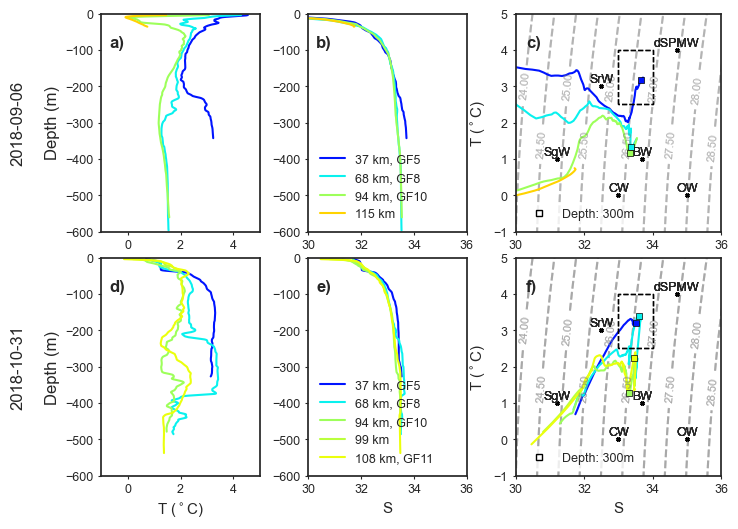

In [41]:
plt.style.use('seaborn-ticks')
from matplotlib.lines import Line2D


# name  = 'every_phase'
# dates = [['2018-05-04', '2018-06-06',  '2018-09-06',  '2018-10-31', '2018-12-11',  '2019-03-05',  '2019-04-10', '2019-05-06',]]
# phases = ['I/II', 'II', 'III', 'IV', 'V',  'VI', 'VI', 'I']

name = "intermediate_inflow"
dates = [[  '2018-09-06',  '2018-10-31',]]
# phases = [ 'III', 'IV',]
# 
phases = ['', '', '', '', '',  '', '', '', '', '', '']
# # dates = [[ '2018-12-11',  '2019-03-05',  '2019-04-10', '2019-05-06',]]
# name = "summer_subglacial_with_arrow"
# dates = [[ '2018-06-11', '2018-06-27', '2018-07-18' , '2018-08-08', ]]

# name = 'winter_intermediate'
# dates = [[ '2018-12-11',  '2019-02-05',  '2019-03-05', '2019-04-10', '2019-05-06',]]
# rangeS, rangeT = [32,34], [-.5, 4]

velocity_day = 3
plt.rcParams.update({'font.size': 9})



cmap_profile = plt.cm.jet
unique_distances = np.sort(df_all['Distance'].unique())

rangeT = [-1., 5]
rangeS = [30,36]

WP_melt = dict(T=2, S=33.2)

WP_melt = dict(T=1, S=33)
WP_mix =  dict(T=4, S=33)


def add_depth_marker(dfst, point_depth, ax, marker, color):
    df_point_depth = dfst[dfst['Pressure'] == point_depth]
    ax.scatter(df_point_depth['Salinity [PSU]'], df_point_depth['Potential temperature [°C]'], s=20, edgecolors='black', facecolors=color, marker=marker, zorder=10)
    
    # Create a custom legend handle for the marker
    custom_marker = Line2D([0], [0], marker=marker, color='w', markerfacecolor='none', markeredgecolor='black', markersize=5, label=f'Depth: {point_depth}m')
    
    # Get existing handles and labels
    handles, labels = ax.get_legend_handles_labels()
    
    # Append the custom marker to the handles and labels
    handles.append(custom_marker)
    labels.append(f'Depth: {point_depth}m')
    
    # Update the legend, and add a white background
    legend = ax.legend(labels=labels, handles=handles, loc='lower left',frameon=True, facecolor='white', edgecolor='white', framealpha=0.8)



for maxz in [600]:
    plot_height = 3
    nr_rows = len(dates[0])

    fig_profile, axs_profile = plt.subplots(nr_rows, 3, sharey=False, sharex=False, figsize=(8,nr_rows*plot_height), gridspec_kw={'width_ratios': [1, 1, 1.3]})
    
    for i, contour_var in enumerate(['Potential temperature [°C]','Salinity [PSU]',]):
        for j, date in tqdm(enumerate(dates[0])):
            z_var ='Depth'
            fig1, df = plot_transect_from_big_file(date =date, variable_fill=contour_var)   # import df from file
            # xi, yi, zi = grid_data(df.Distance, df[z_var], df[contour_var], interval_x=5, interval_y=2) # grid data with interval of 5 km in x and 2 m in y
            axTS = axs_profile[j,2]

    
            for d in df.Distance.sort_values().unique():
                if min(abs(np.array([37,68,94,118, 110])-d)) > 8 and len(df.Distance.sort_values().unique()) >3 : continue
                dfst = df[df.Distance == d].sort_values('Depth')[:-1]
                dfst = dfst.sort_values(z_var)

                color = cmap_profile((d-unique_distances[0])/ (unique_distances[-1]-unique_distances[0]))  # Assign color based on Distance
                label_name = make_label_name(dfst['St.'].values[0], d)
                axs_profile[j,i].plot(dfst[contour_var].rolling(window=5, center=True).mean(), dfst[z_var], label = label_name , color=color)
                axs_profile[j,i].set_xlim(rangeS)



                # TS diagram
                if contour_var == 'Potential temperature [°C]': 
                    axs_profile[j,i].set_xlim(rangeT)

                    TSdiagram(axTS, np.linspace(rangeS[0]-0.1, rangeS[1]+0.1, 100), Tvals=np.linspace(rangeT[0]-0.1, rangeT[1]+0.1, 100), levels=10, alpha=0.2)
                    # do a rolling average of dst
                    dfstROL = dfst.rolling(window=5, center=True).mean()
                    if maxz <=200:
                        axTS.plot(np.linspace(rangeS[0], 33.75, 100), melt_line(T=WP_melt["T"], S=WP_melt["S"], Sarray=np.linspace(rangeS[0], 33.75, 100)), color='black',  linestyle='-.')
                        axTS.plot(np.linspace(rangeS[0], 33.75, 100), mix_line(T=WP_mix["T"], S=WP_mix['S'], Sarray=np.linspace(rangeS[0], 33.75, 100)), color='black',  linestyle=":")
                    # axTS.scatter(dfst['Salinity [PSU]'],dfst[contour_var],label = f"{d:.0f} km, {dfst['St.'].values[0]}", color=color, s=1)
                    axTS.plot(dfstROL['Salinity [PSU]'],dfstROL[contour_var], color=color, label = "")
                    legendTS = axTS.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., fontsize=8)

                    # for handle in legendTS.legendHandles:
                    #     handle.set_sizes([30])
                    # scatter for depth is 100

                    add_depth_marker(dfst, 300, axTS, 's', color)
                    # add_depth_marker(dfst, 30, axTS, 'o', color)
                    # add_depth_marker(dfst, 80, axTS, 'd', color)

                    add_water_mass(axTS)
                    axTS.set_ylim(rangeT)
                    axTS.set_xlim(rangeS)
                    axTS.tick_params(axis='both', which='major', length=2)

 
                    if date == '2018-06-27':
                        add_arrow(axTS, 30.5, -0.8, 0.1, -10, color='red')
                        add_arrow(axTS, 32.4, 0.2, -0.1, -10, color='red')

                    if date == '2018-07-18':
                        add_arrow(axTS, 30.5, -0.8, 0.1, -10, color='red')
                        add_arrow(axTS, 31.9, -0.3, -0.1, -10, color='red')


            axs_profile[j,i].tick_params(axis='both', which='major', length=2)
            axs_profile[j,i].set_ylim([-maxz, 0])
            if phases[0] == '':
                ylabel = f'{date}'+'\n'+'\n'+ 'Depth (m)'
            else:
                ylabel = f'Phase {phases[j]}' +'\n'+ f'{date}'+'\n'+'\n'+ f'Depth (m)'
            axs_profile[j,0].set_ylabel(ylabel, fontsize=12)
            axs_profile[j,2].set_ylabel('T ($^\circ$C)')

            # add box with corners 33.5, 33.4 and 0.5, 1.5
            axTS.plot(*np.array(rectangle_corner_points(33, 34, 2.5, 4)).T,  linewidth=1, color='black', linestyle='--')

            legendS = axs_profile[j,1].legend()


    for i, ax_prof in enumerate(axs_profile.flat):
        ax_prof.text(0.05, 0.9,  f'{string.ascii_lowercase[i]})', transform=ax_prof.transAxes, fontsize=12, fontweight='bold', va='top')

    fig_profile.subplots_adjust(wspace=0.28, hspace=0.12)
    # plt.show()

axs_profile[-1,0].set_xlabel('T ($^\circ$C)')
axs_profile[-1,1].set_xlabel('S')
axs_profile[-1,2].set_xlabel('S')


# savefig
fig_profile.savefig(f'{figpath}/CTD profiles/FigureS3_CTD_profiles_{name}_{maxz}m.jpg', dpi=300, bbox_inches='tight')
figTS_overview.savefig(f'{figpath}/TS diagram/TS_diagram_{name}_{maxz}m.jpg', dpi=300, bbox_inches='tight')

0it [00:00, ?it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
1it [00:00,  9.18it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with la

/Users/annek/Library/CloudStorage/OneDrive-SharedLibraries-NIOZ/PhD Anneke Vries - General/Figures/CTD profiles/CTD_profiles_winter_intermediate_600m.jpg


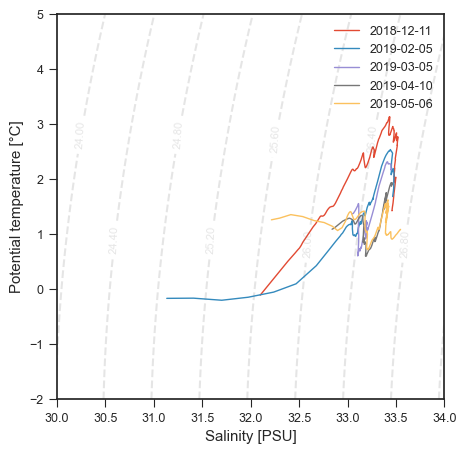

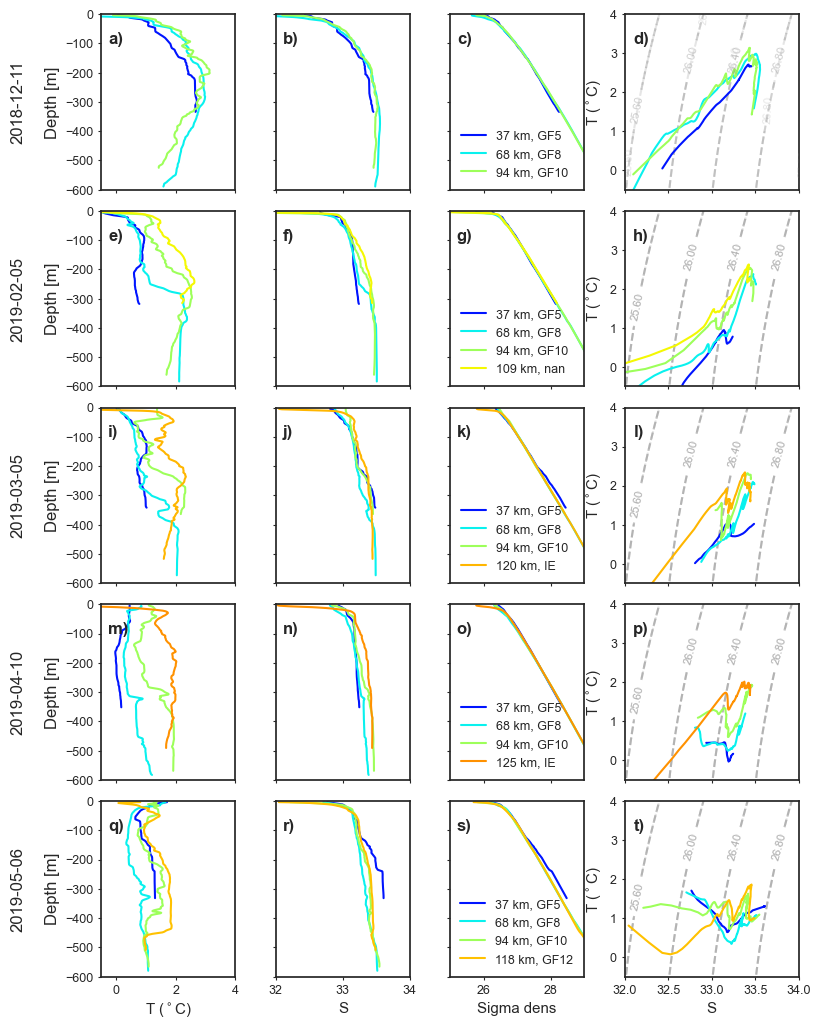

In [33]:
plt.style.use('seaborn-ticks')
from matplotlib.lines import Line2D


# name  = 'every_phase'
# dates = [['2018-05-04', '2018-06-06',  '2018-09-06',  '2018-10-31', '2018-12-11',  '2019-03-05',  '2019-04-10', '2019-05-06',]]
# phases = ['I/II', 'II', 'III', 'IV', 'V',  'VI', 'VI', 'I']
# 
phases = ['', '', '', '', '',  '', '', '', '', '', '']
# dates = [[ '2018-12-11',  '2019-03-05',  '2019-04-10', '2019-05-06',]]
# name = "summer_subglacial_with_arrow"
# dates = [[ '2018-06-11', '2018-06-27', '2018-07-18' , '2018-08-08',  '2018-09-06', '2018-10-15']]

name = 'winter_intermediate'
dates = [[ '2018-12-11',  '2019-02-05',  '2019-03-05', '2019-04-10', '2019-05-06',]]
rangeS, rangeT = [32,34], [-.5, 4]

velocity_day = 3
plt.rcParams.update({'font.size': 9})

figTS_overview, axTSover= plt.subplots(1, 1, figsize=[5,5])
axTSover.set_xlabel('Salinity [PSU]')
axTSover.set_ylabel('Potential temperature [°C]')

cmap_profile = plt.cm.jet
unique_distances = np.sort(df_all['Distance'].unique())

# rangeT = [-1.9, 6]
# rangeS = [25,35]
rangeSigmaD = [25, 29]


WP_melt = dict(T=2, S=33.2)

WP_melt = dict(T=1, S=33)
WP_mix =  dict(T=4, S=33)

TSdiagram(axTSover, np.linspace(25, 35, 100), Tvals=np.linspace(-2,5, 100), levels=20, alpha=0.2)




# def add_arrow(ax, x, y, x_length, y_length, color='red'):
#     ax.annotate('', xy=(x, y), xytext=(x + x_length, y + y_length), textcoords='offset points', arrowprops=dict(facecolor=color, edgecolor=color, arrowstyle='->', linewidth=2))

for maxz in [600]:

    plot_height = 2.5
    nr_rows = len(dates[0])

    fig_profile, axs_profile = plt.subplots(nr_rows, 4, sharey=False, sharex="col", figsize=(9,nr_rows*plot_height), gridspec_kw={'width_ratios': [1, 1, 1, 1.3]})

    
    for i, contour_var in enumerate(['Potential temperature [°C]','Salinity [PSU]','Sigma_dens']):
        for j, date in tqdm(enumerate(dates[0])):
            z_var ='Depth'
            fig1, df = plot_transect_from_big_file(date =date, variable_fill=contour_var)   # import df from file
            # xi, yi, zi = grid_data(df.Distance, df[z_var], df[contour_var], interval_x=5, interval_y=2) # grid data with interval of 5 km in x and 2 m in y
            axTS = axs_profile[j,3]

    
            for d in df.Distance.sort_values().unique():
                if min(abs(np.array([37,68,94,118, 110])-d)) > 8 and len(df.Distance.sort_values().unique()) >3 : continue
                dfst = df[df.Distance == d].sort_values('Depth')[:-1]
                dfst = dfst.sort_values(z_var)

                color = cmap_profile((d-unique_distances[0])/ (unique_distances[-1]-unique_distances[0]))  # Assign color based on Distance
                axs_profile[j,i].plot(dfst[contour_var].rolling(window=5, center=True).mean(), dfst[z_var], label = f"{d:.0f} km, {dfst['St.'].values[0]}", color=color)
                axs_profile[j,i].set_xlim(rangeS)

                if i >0:
                    axs_profile[j,i].set_yticklabels([])

                legendS = axs_profile[j,-2].legend()



                # TS diagram
                if contour_var == 'Potential temperature [°C]': 
                    axs_profile[j,i].set_xlim(rangeT)

                    TSdiagram(axTS, np.linspace(rangeS[0]*0.9, rangeS[1]*1.1, 100), Tvals=np.linspace(rangeT[0]*0.9, rangeT[1]*1.1, 100), levels=20, alpha=0.2)
                    # do a rolling average of dst
                    dfstROL = dfst.rolling(window=5, center=True).mean()
                    if maxz <=200:
                        axTS.plot(np.linspace(rangeS[0], 33.75, 100), melt_line(T=WP_melt["T"], S=WP_melt["S"], Sarray=np.linspace(rangeS[0], 33.75, 100)), color='black',  linestyle='-.')
                        axTS.plot(np.linspace(rangeS[0], 33.75, 100), mix_line(T=WP_mix["T"], S=WP_mix['S'], Sarray=np.linspace(rangeS[0], 33.75, 100)), color='black',  linestyle=":")
                    # axTS.scatter(dfst['Salinity [PSU]'],dfst[contour_var],label = f"{d:.0f} km, {dfst['St.'].values[0]}", color=color, s=1)
                    axTS.plot(dfstROL['Salinity [PSU]'],dfstROL[contour_var],label = f"{d:.0f} km, {dfst['St.'].values[0]}", color=color,)
                    # legendTS = axTS.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., fontsize=8)
                    # for handle in legendTS.legendHandles:
                    #     handle.set_sizes([30])
                    # scatter for depth is 100                       
                        

                    # add_depth_marker(dfst, 10, axTS, 's', color)
                    # add_depth_marker(dfst, 30, axTS, 'o', color)
                    # add_depth_marker(dfst, 80, axTS, 'd', color)

                    # add_water_mass(axTS)
                    axTS.set_ylim(rangeT)
                    axTS.set_xlim(rangeS)
                    axTS.tick_params(axis='both', which='major', length=2)
                    if 'GF10' in dfst['St.'].to_list():
                        # arange dfst by z_var

                        # axTSover.plot(dfst['Salinity [PSU]'],dfst['Potential temperature [°C]'], linewidth=.5, label=date)
                        axTSover.plot(dfstROL['Salinity [PSU]'],dfstROL['Potential temperature [°C]'], linewidth=1, label=date)

                    # elif 'GF5' in dfst['St.'].to_list():
                    #     axTSover.plot(dfst['Salinity [PSU]'],dfst['Potential temperature [°C]'], linewidth=0.5, linestyle='dashed', label=date)
 
                    if date == '2018-06-27':
                        draw_arrow(axTS, 30.9, -0.8, 0.2, 1, color='red')
                        draw_arrow(axTS, 32.4, 0.2, -0.1, 1, color='red')

                    if date == '2018-07-18':
                        draw_arrow(axTS, 30.7, -0.6, 0.1, 1, color='red')
                        draw_arrow(axTS, 31.9, -0.3, -0.2, 1, color='red')
                    if date == '2018-08-08':
                        draw_arrow(axTS, 30.2, 0.3, 0.3, 1, color='red')
                        draw_arrow(axTS, 31.7, 0.3, -0.4, 1, color='red')
                    if date == '2018-09-06':
                        draw_arrow(axTS, 29, -0.1, 0.3, 1, color='red')
                        draw_arrow(axTS, 31.7, 0.6, -0.8, 1, color='red')



            axs_profile[j,i].tick_params(axis='both', which='major', length=2)
            axs_profile[j,i].set_ylim([-maxz, 0])
            if phases[0] == '':
                ylabel = f'{date}'+'\n'+'\n'+ 'Depth [m]'
            else:
                ylabel = f'Phase {phases[j]}' +'\n'+ f'{date}'+'\n'+'\n'+ f'Depth (m)'
            axs_profile[j,0].set_ylabel(ylabel, fontsize=12)
            axs_profile[j,3].set_ylabel('T ($^\circ$C)')


            # # add box with corners 33.5, 33.4 and 0.5, 1.5
            # axTS.plot(*np.array(rectangle_corner_points(33.4, 33.6, 0.5, 1.5)).T,  linewidth=1)

    for i, ax_prof in enumerate(axs_profile.flat):
        ax_prof.text(0.05, 0.9,  f'{string.ascii_lowercase[i]})', transform=ax_prof.transAxes, fontsize=12, fontweight='bold', va='top')

    fig_profile.subplots_adjust(wspace=0.28, hspace=0.12)
    axTSover.legend()
    axTSover.set_xlim(30, 34)
    # plt.show()
axs_profile[-1,2].set_xlim(rangeSigmaD)

axs_profile[-1,0].set_xlabel('T ($^\circ$C)')
axs_profile[-1,1].set_xlabel('S')
axs_profile[-1,2].set_xlabel('Sigma dens')
axs_profile[-1,3].set_xlabel('S')
# plt.tight_layout()

# savefig
fig_profile.savefig(f'{figpath}/CTD profiles/CTD_profiles_{name}_{maxz}m.jpg', dpi=300, bbox_inches='tight')
print(f'{figpath}/CTD profiles/CTD_profiles_{name}_{maxz}m.jpg')


In [25]:
df

Pressure       timeJ  tv290C     c0S/m     flSP          par  \
35693       1.0  126.648361  2.3513  2.805884  0.18729  1151.600000   
35694       2.0  126.648404  2.1708  2.800839  0.20773   853.920000   
35695       3.0  126.648432  1.3661  2.773299  0.18713   641.430000   
35696       4.0  126.648459  0.3743  2.721769  0.20518   514.580000   
35697       5.0  126.648485  0.1243  2.714052  0.23974   439.260000   
...         ...         ...     ...       ...      ...          ...   
69185     564.0  126.562871  1.1146  2.912253  0.11496     0.000059   
69186     565.0  126.562887  1.1135  2.912160  0.12296     0.000067   
69187     566.0  126.562902  1.1130  2.912139  0.11892     0.000064   
69188     567.0  126.562918  1.1130  2.912195  0.12035     0.000050   
69189     568.0  126.562935  1.1131  2.912245  0.13477     0.000054   

       sbox0Mm/Kg  seaTurbMtr    scan    depSM  ...        Date  Type  \
35693     151.335       2.190  1015.0    0.990  ...  2019-05-06   CTD   
35694     155.207       2.139  1029.0    1.981  ...  2019-05-06   CTD   
35695     154.824       1.987  1039.0    2.971  ...  2019-05-06   CTD   
35696     158.982       2.001  1048.0    3.961  ...  2019-05-06   CTD   
35697     158.921       1.957  1057.0    4.951  ...  2019-05-06   CTD   
...           ...         ...     ...      ...  ...         ...   ...   
69185     156.174       1.285  3713.0  557.743  ...  2019-05-06   CTD   
69186     155.490       1.158  3719.0  558.731  ...  2019-05-06   CTD   
69187     155.545       1.183  3724.0  559.718  ...  2019-05-06   CTD   
69188     155.445       1.091  3729.0  560.706  ...  2019-05-06   CTD   
69189     155.621       1.271  3735.0  561.693  ...  2019-05-06   CTD   

          Name  YYYYMMDD  Distance  Depth   Plot_date         SA        CT  \
35693  GF19038  20190506     117.7   -1.0  2019-05-06  31.401882  2.376082   
35694  GF19038  20190506     117.7   -2.0  2019-05-06  31.518430  2.194028   
35695  GF19038  20190506     117.7   -3.0  2019-05-06  31.982719  1.383434   
35696  GF19038  20190506     117.7   -4.0  2019-05-06  32.345630  0.386724   
35697  GF19038  20190506     117.7   -5.0  2019-05-06  32.507793  0.135368   
...        ...       ...       ...    ...         ...        ...       ...   
69185  GF19036  20190506      94.0 -564.0  2019-05-06  33.708106  1.094829   
69186  GF19036  20190506      94.0 -565.0  2019-05-06  33.707604  1.093631   
69187  GF19036  20190506      94.0 -566.0  2019-05-06  33.707302  1.093132   
69188  GF19036  20190506      94.0 -567.0  2019-05-06  33.707504  1.093131   
69189  GF19036  20190506      94.0 -568.0  2019-05-06  33.707403  1.093131   

      Sigma_dens  
35693  24.952902  
35694  25.063586  
35695  25.492944  
35696  25.844668  
35697  25.991882  
...          ...  
69185  29.533182  
69186  29.537563  
69187  29.542047  
69188  29.546890  
69189  29.551493  

[3019 rows x 29 columns]

# Isopycnal depth

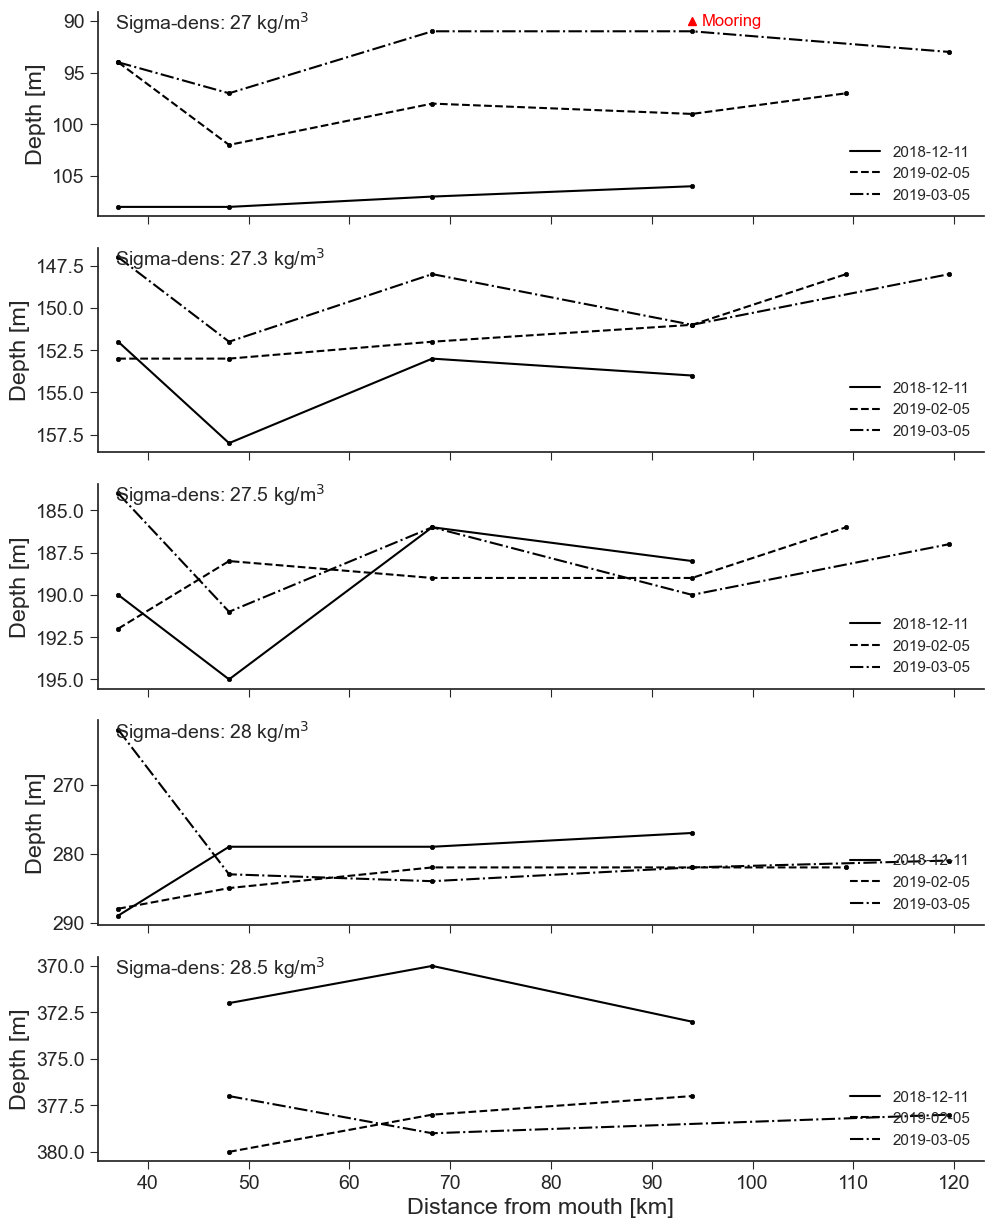

In [ ]:
# dates_isopycnal =  [ '2018-12-11', '2019-02-05',  '2019-03-05', '2019-04-10',]# '2019-05-06',]
dates_isopycnal =  [ '2018-12-11',  '2019-02-05',  '2019-03-05',]
densities_isopycnal = [27, 27.3, 27.5, 28, 28.5,]
# densities_isopycnal = [ 27.5, 28,]

dashstyles = ['-', '--', '-.', ':']
fig, axs = plt.subplots(len(densities_isopycnal), 1, figsize=(10, 2.5*len(densities_isopycnal)), sharey=False, sharex=True)
cmap = cm.get_cmap('viridis')

for i, density in enumerate(densities_isopycnal):
    ax = axs[i]
    for j, date in enumerate(dates_isopycnal):
        # Get the data for the current date
        df_date = df_all[df_all['Date'] == date]
        df_date = df_date.sort_values('Distance')
        df_date['Depth'] = -df_date['Depth']
        Names = df_date['Name'].unique()
        depth_at_density = []
        distances_dens = []

        for st in Names:
            df_distance = df_date[df_date['Name'] == st]
            distance = df_distance['Distance'].mean()
            if df_distance.empty:
                continue
            # if 'GF5' in df_distance['St.'].to_list():
            #     continue
            if df_distance['Sigma_dens'].max() < density:
                continue
            closest_depth = df_distance.iloc[(df_distance['Sigma_dens'] - density).abs().argsort()[:1]]['Depth'].values[0]
            distances_dens.append(distance)
            depth_at_density.append(closest_depth)

        ax.plot(distances_dens, depth_at_density, label=date, linestyle=dashstyles[j], color="black")
        ax.scatter(distances_dens, depth_at_density, s=10, color="black")
    ax.text(0.02, 1.01, f'Sigma-dens: {density} kg/m$^3$', ha='left', va='top', transform= ax.transAxes, )
    ax.set_ylabel('Depth [m]')

    # make xticks every 10 km
    ax.set_xticks(np.arange(40, 140, 10))
    ax.set_xlim([35, 123])
    ax.legend( loc = 'lower right', fontsize= 11)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # invert y-axis
    ax.invert_yaxis()


# in ax[0] make a red triangle with text mooring at x = 95 and y = 100
axs[0].plot(94, 90, 'r^')
axs[0].text(95, 90, 'Mooring', color='red', fontsize=12, ha='left', va='center')

axs[-1].set_xlabel('Distance from mouth [km]')
direction = [ "in", "out"]
# for i, ax in enumerate(axs):
#     ax.text(0.5, 0.5, f'{direction[i]}', fontsize=12, ha='center', va='center', transform= ax.transAxes, fontweight='bold')


plt.tight_layout()

plt.savefig(f'{figpath}/isopycnal_depth_large.png', dpi=300, bbox_inches='tight')

plt.show()

In [43]:
df

Pressure       timeJ  tv290C     c0S/m      flSP          par  \
40502       1.0  182.651768  3.7155  1.030035  0.067532  2536.800000   
40503       2.0  182.651821  3.8286  1.035381  0.058694  1813.000000   
40504       3.0  182.651853  2.8330  1.599074  0.109670  1272.900000   
40505       4.0  182.651882  0.5921  2.508132  0.108520   918.150000   
40506       5.0  182.651903  0.2817  2.516405  0.580150   656.360000   
...         ...         ...     ...       ...       ...          ...   
52627     593.0  182.515539  1.0526  2.902519  0.046616     0.000084   
52628     594.0  182.515555  1.0520  2.902599  0.048458     0.000068   
52629     595.0  182.515571  1.0514  2.902711  0.046476     0.000100   
52630     596.0  182.515587  1.0514  2.902765  0.051169     0.000080   
52631     597.0  182.515605  1.0514  2.902788  0.047722     0.000074   

       sbox0Mm/Kg  seaTurbMtr    scan    depSM  ...        Date  Type  \
40502     376.389       3.959   580.0    0.990  ...  2019-07-01   CTD   
40503     406.558       3.652   598.0    1.981  ...  2019-07-01   CTD   
40504     498.040       3.219   610.0    2.971  ...  2019-07-01   CTD   
40505     505.060       3.019   619.0    3.961  ...  2019-07-01   CTD   
40506     457.440       3.052   627.0    4.951  ...  2019-07-01   CTD   
...           ...         ...     ...      ...  ...         ...   ...   
52627     314.501       0.562  3731.0  586.381  ...  2019-07-01   CTD   
52628     314.332       0.667  3737.0  587.368  ...  2019-07-01   CTD   
52629     314.295       0.600  3742.0  588.356  ...  2019-07-01   CTD   
52630     313.589       0.722  3748.0  589.343  ...  2019-07-01   CTD   
52631     313.715       0.680  3754.0  590.331  ...  2019-07-01   CTD   

          Name  YYYYMMDD    Distance  Depth   Plot_date         SA        CT  \
40502  GF19064  20190701  132.631513   -1.0  2019-07-01  10.125614  3.893846   
40503  GF19064  20190701  132.631513   -2.0  2019-07-01  10.139479  4.010961   
40504  GF19064  20190701  132.631513   -3.0  2019-07-01  16.860916  2.950877   
40505  GF19064  20190701  132.631513   -4.0  2019-07-01  29.245693  0.618437   
40506  GF19064  20190701  132.631513   -5.0  2019-07-01  29.760923  0.303872   
...        ...       ...         ...    ...         ...        ...       ...   
52627  GF19060  20190701   68.210000 -593.0  2019-07-01  33.633958  1.032091   
52628  GF19060  20190701   68.210000 -594.0  2019-07-01  33.635064  1.031384   
52629  GF19060  20190701   68.210000 -595.0  2019-07-01  33.636571  1.030775   
52630  GF19060  20190701   68.210000 -596.0  2019-07-01  33.636672  1.030674   
52631  GF19060  20190701   68.210000 -597.0  2019-07-01  33.636471  1.030575   

      Sigma_dens  
40502   8.019463  
40503   8.031886  
40504  13.389533  
40505  23.351325  
40506  23.782229  
...          ...  
52627  29.615165  
52628  29.620783  
52629  29.626712  
52630  29.631482  
52631  29.636013  

[2562 rows x 29 columns]

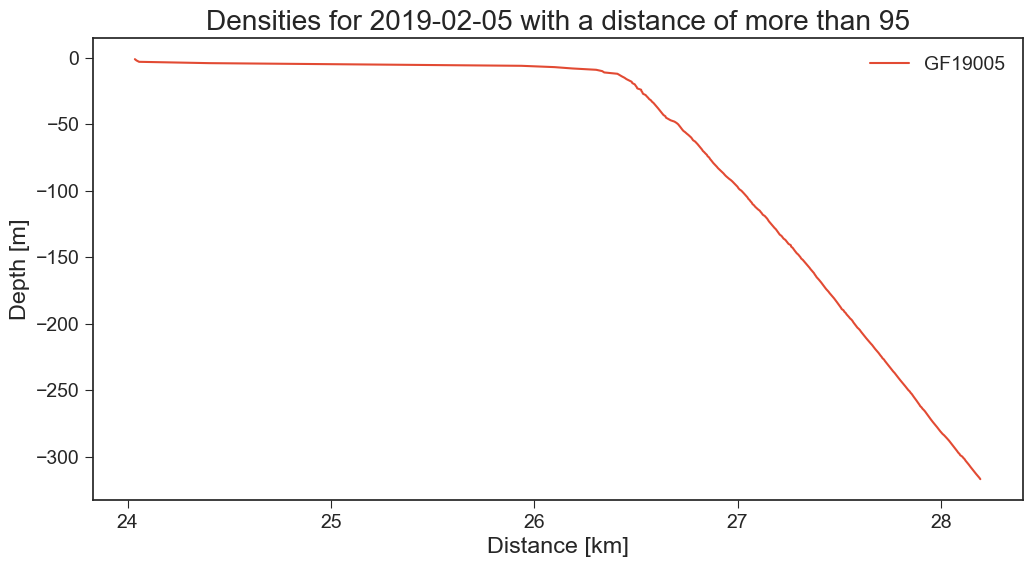

In [222]:
# Select the data for the date '2019-02-05' and a distance of more than 95
df_date = df_all[(df_all['Date'] == '2019-02-05') & (df_all['Distance'] > 95)]

# Create a new figure
fig, ax = plt.subplots(figsize=(12, 6))

# Loop over each density
depth_at_density = []
distances_dens = []

# Loop over each distance
for st in df_date['Name'].unique():
    # Get the data for the current distance
    df_distance = df_date[df_date['Name'] == st]


    # Plot distance versus depth where the density is the given density
    ax.plot(df_distance['Sigma_dens'], df_distance['Depth'],  label=f"{st}")

# Set the labels and title
ax.set_xlabel('Distance [km]')
ax.set_ylabel('Depth [m]')
ax.set_title('Densities for 2019-02-05 with a distance of more than 95')

# Add a legend
ax.legend()

# Show the figure
plt.show()

In [17]:
import matplotlib as mpl
import cmocean as cmo
from tqdm import tqdm
import cmcrameri 
plt.style.use('seaborn-ticks')

dates = [['2018-06-06',   '2018-08-09', '2018-09-06',  '2018-10-31', '2018-12-11',  '2019-03-05',  '2019-04-10', '2019-05-06',]]
phases = ['I/II', 'II', 'III', 'IV', 'V',  'VI', 'VI', 'I']

maxz = 100
velocity_day = 3



plt.rcParams.update({'font.size': 9})

cmap_profile = plt.cm.jet

unique_distances = np.sort(df_all['Distance'].unique())
min_distance = unique_distances[0]

part = 0
for maxz in [600]:
    plot_height = 15/7.5
    nr_rows = len(dates[part])

    fig, axs = plt.subplots(nr_rows, 2, sharey=True, sharex=True, figsize=(mm2inch(190), mm2inch(230))
    for j, date in tqdm(enumerate(dates[part])):

        for i, contour_var in enumerate(['Potential temperature [°C]','Salinity [PSU]',]):
            z_var ='Depth'
            fig1, df = plot_transect_from_big_file(date =date, variable_fill=contour_var)   # import df from file
            levels, subplot_letter, colorscale, clabel = colors(contour_var, nrows=np.shape(axs)[0])
            xi, yi, zi = grid_data(df.Distance, df[z_var], df[contour_var], interval_x=5, interval_y=2) # grid data with interval of 5 km in x and 2 m in y

            # ... rest of the code for plotting ...
            if contour_var == 'Potential temperature [°C]':
                colorscale = mpl.colors.ListedColormap(cmo.cm.thermal(np.linspace(0, 1, 15)))
                cmap = colorscale
                bounds =[-1.8, 0,0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 2,2.25, 2.5,2.75,3, 3.5 , 10] 
                norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
                levels_l =[-1.8, 0, 1,  2,  3, 3.5, 10] 
                color_contourline = 'black'
                color_contourline = np.array(['black' if i > 0 else 'white' for i in levels_l])
            else:
                colorscale = mpl.colors.ListedColormap(['blue', 'cyan', 'green', 'red', 'purple', 'yellow'])
                cmap = colorscale
                colorscale = mpl.colors.ListedColormap(cmo.cm.haline(np.linspace(0, 1, 6)))
                bounds = [7.5, 30.5, 32.8, 33.2, 33.4,  33.5, 33.7]
                norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
                color_contourline = np.array(['black' if i >= 30.5 else 'white' for i in levels_l]) 
                short_label = 'Salinity'
                levels_l =np.sort(np.concatenate([np.arange(30, 33, 1),  np.arange(33,33.56, 0.1), np.arange(33.6, 35.1, 0.4)]))

            cfill = axs[j, i].contourf(xi, yi, zi,  levels=bounds, cmap=colorscale, extend=None,norm=norm, alpha=0.9)
            cline = axs[j, i].contour(xi, yi, zi,levels=levels_l, colors=color_contourline, linewidths=0.5  )  #     )
            q= add_velocity_vectors(axs[j,i], pd.to_datetime(date) - pd.Timedelta(days=1), n=2, width=6e-3, velocity_day=velocity_day, Hz='both', nmeters=4.0)
            axs[j, i].clabel(cline, cline.levels, inline=True, fontsize=7, zorder=16, fmt=fmt_label) # add labels to contours
        
            if contour_var == 'Potential temperature [°C]':
                cCT = cfill
            elif contour_var == 'Salinity [PSU]':
                cSA = cfill
    add_colorbar_john(fig, cCT, cSA, second_cbar_ax=False, y_pos=0.9, y_height=0.010, templabel=r"$\theta$ [$^\circ$C]", sallabel='S ', Tticks= [-1.8, 0, 0.5, 1, 1.5,2,2.5,   3, 3.5, 10] )

    # Set axis labels
    axs[-1, 0].set_xlabel('Distance from mouth [km]')
    axs[-1, 1].set_xlabel('Distance from mouth [km]')
    for ax in axs.flat:
        ax.set_ylim([ -maxz, -0])
        ax.set_xlim([ 35, 135])
        ax.tick_params(axis='both', which='major', length=3)
    for i in range(np.shape(axs)[0]): axs[i, 1].set_ylabel('')
    # Adjust spacing between subplots
    fig.subplots_adjust(wspace=0.06, hspace=0.13)
    axs[-1,0].quiverkey(q, X=0.5, Y=0.07, U=30,
                label='3 cm/s', labelpos='E', coordinates='figure')

    plt.show()

SyntaxError: Generator expression must be parenthesized (966801112.py, line 34)

GIF

## Single transect

In [30]:
df.columns

Index(['Pressure', 'timeJ', 'tv290C', 'c0S/m', 'flSP', 'par', 'sbox0Mm/Kg',
       'seaTurbMtr', 'scan', 'depSM', 'Salinity [PSU]',
       'Potential temperature [°C]', 'sigma-�00', 'Density [kg/m3]', 'svCM',
       'flag', 'Latitude', 'Longitude', 'St.', 'Date', 'Type', 'Name',
       'YYYYMMDD', 'Distance', 'Depth', 'Plot_date', 'SA', 'CT', 'Sigma_dens'],
      dtype='object')

In [107]:
pd.options.plotting.backend = "plotly"
df['Sigma_dens'].plot.hist()

# make quantiles for every 0.1  
quantiles = df_all['Sigma_dens'].quantile(np.arange(0,1.1,0.1)).round(1).to_numpy()
print(quantiles)
# now make a hist iwht qunatiles
# use matplotlib
# set cmap wiith cmocean density
np.concatenate([np.arange(3, 26,5), np.arange(26,28, 0.5), np.arange(28, 29.8, 0.1)])

[ 3.6 26.3 26.8 27.1 27.4 27.7 28.  28.3 28.6 29.  29.8]


array([ 3. ,  8. , 13. , 18. , 23. , 26. , 26.5, 27. , 27.5, 28. , 28.1,
       28.2, 28.3, 28.4, 28.5, 28.6, 28.7, 28.8, 28.9, 29. , 29.1, 29.2,
       29.3, 29.4, 29.5, 29.6, 29.7, 29.8])

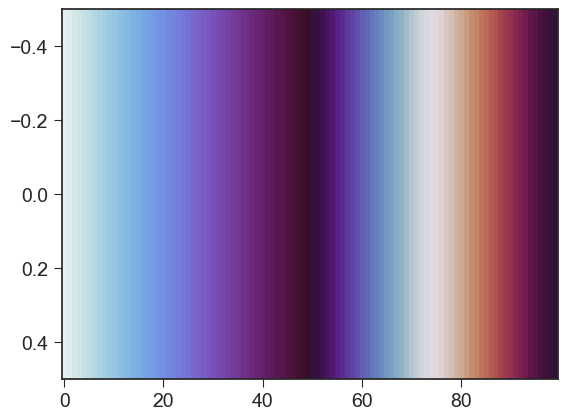

In [39]:
pd.options.plotting.backend = "plotly"
average_per_pressure = df_all.groupby('Pressure')['Sigma_dens'].mean()
fig = average_per_pressure.to_frame().reset_index().plot.line(y='Pressure', x='Sigma_dens')
fig.update_yaxes(autorange="reversed")
fig.update_layout(width=500)
# show fig
fig.show()

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cmocean

# Create a white to dense colormap
dense = cmocean.cm.dense(np.linspace(0, 1, 128))

# Create a dense to purple colormap
purple = plt.cm.twilight_shifted(np.linspace(0, 1, 128))

# Combine the colormaps
colors = np.vstack((dense, purple))
my_dens_map = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)

# Use the colormap
plt.imshow([np.linspace(0,1,100)], aspect='auto', cmap=mymap)
plt.show()


In [36]:
df[df['Type']=='CTD']

Pressure       timeJ  tv290C     c0S/m     flSP          par  \
35693       1.0  126.648361  2.3513  2.805884  0.18729  1151.600000   
35694       2.0  126.648404  2.1708  2.800839  0.20773   853.920000   
35695       3.0  126.648432  1.3661  2.773299  0.18713   641.430000   
35696       4.0  126.648459  0.3743  2.721769  0.20518   514.580000   
35697       5.0  126.648485  0.1243  2.714052  0.23974   439.260000   
...         ...         ...     ...       ...      ...          ...   
69185     564.0  126.562871  1.1146  2.912253  0.11496     0.000059   
69186     565.0  126.562887  1.1135  2.912160  0.12296     0.000067   
69187     566.0  126.562902  1.1130  2.912139  0.11892     0.000064   
69188     567.0  126.562918  1.1130  2.912195  0.12035     0.000050   
69189     568.0  126.562935  1.1131  2.912245  0.13477     0.000054   

       sbox0Mm/Kg  seaTurbMtr    scan    depSM  ...        Date  Type  \
35693     151.335       2.190  1015.0    0.990  ...  2019-05-06   CTD   
35694     155.207       2.139  1029.0    1.981  ...  2019-05-06   CTD   
35695     154.824       1.987  1039.0    2.971  ...  2019-05-06   CTD   
35696     158.982       2.001  1048.0    3.961  ...  2019-05-06   CTD   
35697     158.921       1.957  1057.0    4.951  ...  2019-05-06   CTD   
...           ...         ...     ...      ...  ...         ...   ...   
69185     156.174       1.285  3713.0  557.743  ...  2019-05-06   CTD   
69186     155.490       1.158  3719.0  558.731  ...  2019-05-06   CTD   
69187     155.545       1.183  3724.0  559.718  ...  2019-05-06   CTD   
69188     155.445       1.091  3729.0  560.706  ...  2019-05-06   CTD   
69189     155.621       1.271  3735.0  561.693  ...  2019-05-06   CTD   

          Name  YYYYMMDD  Distance  Depth   Plot_date         SA        CT  \
35693  GF19038  20190506     117.7   -1.0  2019-05-06  31.401882  2.376082   
35694  GF19038  20190506     117.7   -2.0  2019-05-06  31.518430  2.194028   
35695  GF19038  20190506     117.7   -3.0  2019-05-06  31.982719  1.383434   
35696  GF19038  20190506     117.7   -4.0  2019-05-06  32.345630  0.386724   
35697  GF19038  20190506     117.7   -5.0  2019-05-06  32.507793  0.135368   
...        ...       ...       ...    ...         ...        ...       ...   
69185  GF19036  20190506      94.0 -564.0  2019-05-06  33.708106  1.094829   
69186  GF19036  20190506      94.0 -565.0  2019-05-06  33.707604  1.093631   
69187  GF19036  20190506      94.0 -566.0  2019-05-06  33.707302  1.093132   
69188  GF19036  20190506      94.0 -567.0  2019-05-06  33.707504  1.093131   
69189  GF19036  20190506      94.0 -568.0  2019-05-06  33.707403  1.093131   

      Sigma_dens  
35693  24.952902  
35694  25.063586  
35695  25.492944  
35696  25.844668  
35697  25.991882  
...          ...  
69185  29.533182  
69186  29.537563  
69187  29.542047  
69188  29.546890  
69189  29.551493  

[3019 rows x 29 columns]

12it [00:26,  2.24s/it]


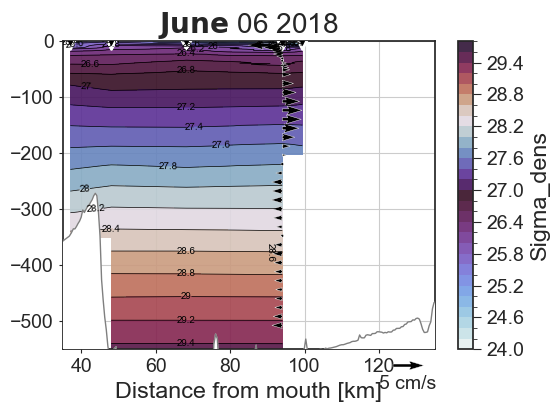

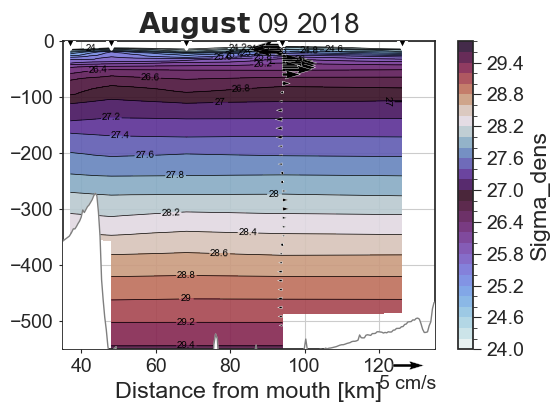

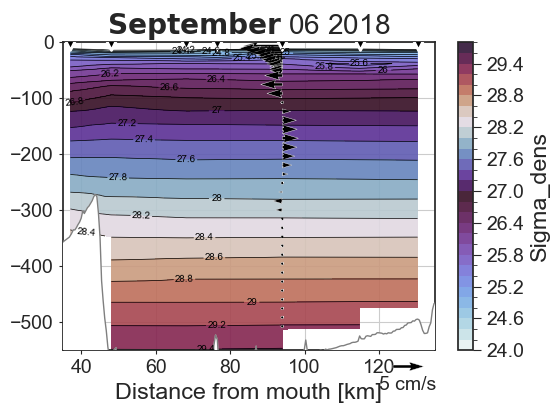

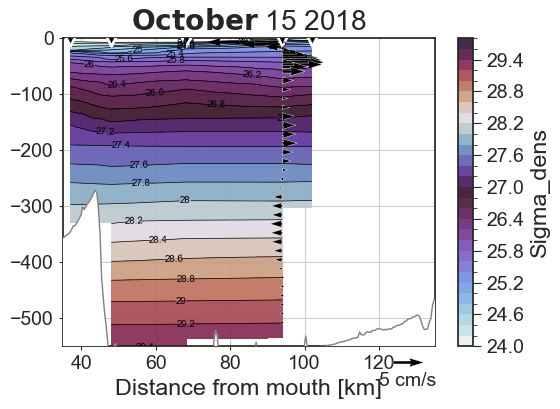

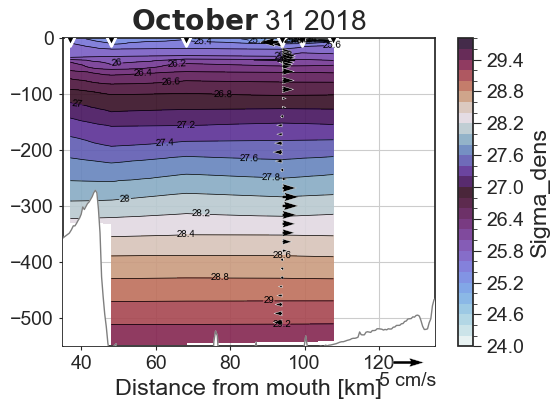

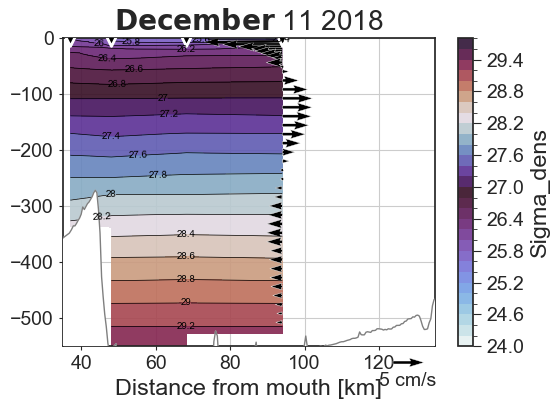

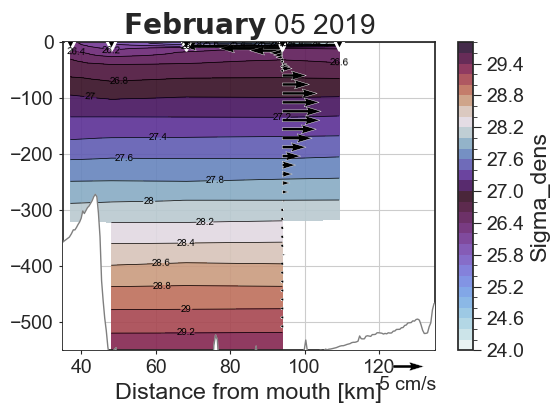

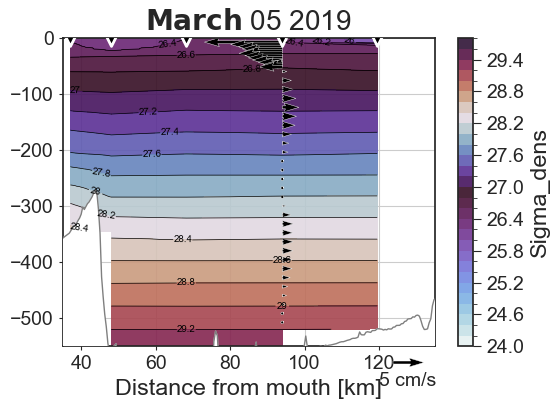

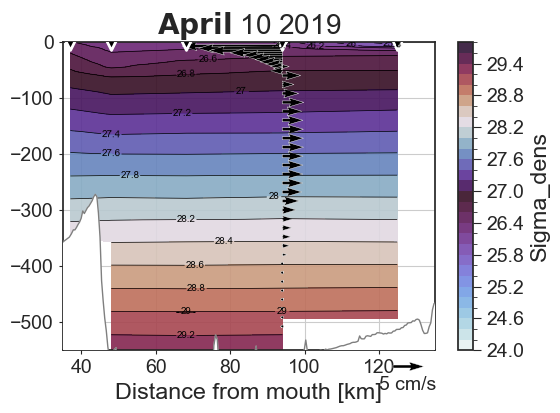

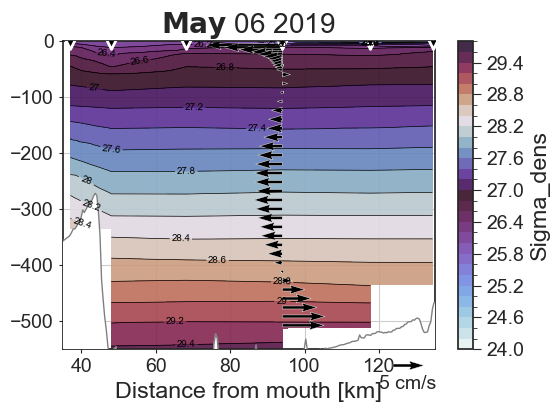

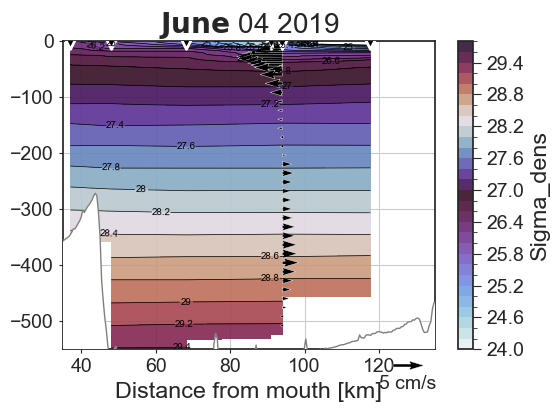

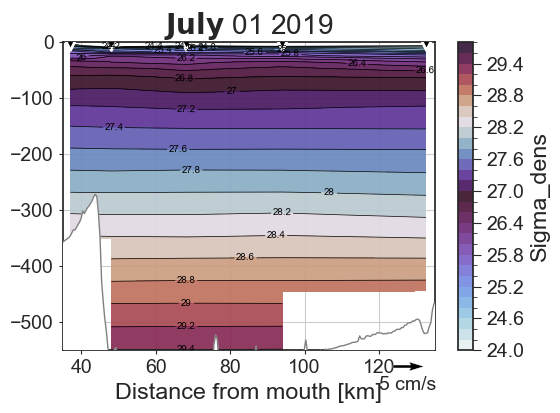

In [42]:
import matplotlib as mpl
import cmocean as cmo
from tqdm import tqdm
import cmcrameri 
plt.style.use('seaborn-ticks')

velocity_day = 7

dates = ['2018-06-06',  '2018-08-09',  '2018-09-06', '2018-10-15', '2018-10-31', 
         '2018-12-11',  '2019-02-05',  '2019-03-05', '2019-04-10', '2019-05-06','2019-06-04', '2019-07-01', ]

unique_distances = np.sort(df_all['Distance'].unique())
min_distance = unique_distances[0]
# change fontsize
plt.rcParams.update({'font.size': 14})

for maxz in [550]:


    for j, date in tqdm(enumerate(dates)):
        fig, ax = plt.subplots(figsize=(6,4))
        
        contour_var = 'Sigma_dens'
        z_var ='Depth'
        fig1, df = plot_transect_from_big_file(date =date, variable_fill=contour_var)   # import df from file
        df[df['Type']=='CTD']
        # levels, subplot_letter, colorscale, clabel = colors(contour_var, nrows=np.shape(axs)[0])
        xi, yi, zi = grid_data(df.Distance, df[z_var], df[contour_var], interval_x=5, interval_y=2) # grid data with interval of 5 km in x and 2 m in y

        # ... rest of the code for plotting ...
        colorscale = mpl.colors.ListedColormap(cmo.cm.thermal(np.linspace(0, 1, 15)))
        cmap = colorscale
        cmap = cmo.cm.dense
        cmap =  my_dens_map
        bounds =[-1.8, 0,0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 2,2.25, 2.5,2.75,3, 3.5 , 10] 
        bounds = df_all[contour_var].quantile(np.arange(0,1.001,0.05)).round(1).to_numpy()
        bounds = np.concatenate([[3],np.arange(22, 26,2), np.arange(26,28, 0.2), np.arange(28, 29.8, 0.2)])
        bounds = np.arange(24,30, 0.2)
        norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
        levels_l =[-1.8, 0, 1,  2,  3, 3.5, 10] 
        color_contourline = 'black'
        # color_contourline = np.array(['black' if i > 0 else 'white' for i in levels_l])

        cfill = ax.contourf(xi, yi, zi,   levels=bounds, cmap=cmap, extend=None,norm=norm, alpha=0.9)
        cline = ax.contour(xi, yi, zi, levels=bounds, colors=color_contourline, linewidths=0.5  )  #     )
        q= add_velocity_vectors(ax, pd.to_datetime(date) - pd.Timedelta(days=1), n=2, width=8e-3, velocity_day=velocity_day, Hz='both', nmeters=4.0)
        ax.clabel(cline, cline.levels, inline=True, fontsize=7, zorder=16, fmt=fmt_label) # add labels to contours
        plot_stations(df, ax, depth=-5, text=False, s=50)
        bathymetry_line(ax, df_bath)
        fig.colorbar(cfill, ax=ax, orientation='vertical', label=contour_var,)

        ax.set_title(r'$\bf{%s}$ %s %s' % (pd.to_datetime(date).strftime('%B'), pd.to_datetime(date).strftime('%d'), pd.to_datetime(date).strftime('%Y')))
        ax.set_xlabel('Distance from mouth [km]')
        ax.set_ylim([ -maxz, -0])
        ax.set_xlim([ 35, 135])
        ax.tick_params(axis='both', which='major', length=3)
        ax.set_ylabel('')
        fig.subplots_adjust(wspace=0.06, hspace=0.07)
        ax.quiverkey(q, X=0.7, Y=0.07, U=50,
                    label='5 cm/s', labelpos='S', coordinates='figure')
        # add grid
        ax.grid(True, alpha = 1)

        fig.savefig(f'{figpath}/lenght_transect/Single transect/dens/{date}_CT_transect_reduced_z_{maxz}_velocity_every_{velocity_day}_day.jpg', dpi=300, bbox_inches='tight')
        fig.show()

12it [01:00,  5.03s/it]


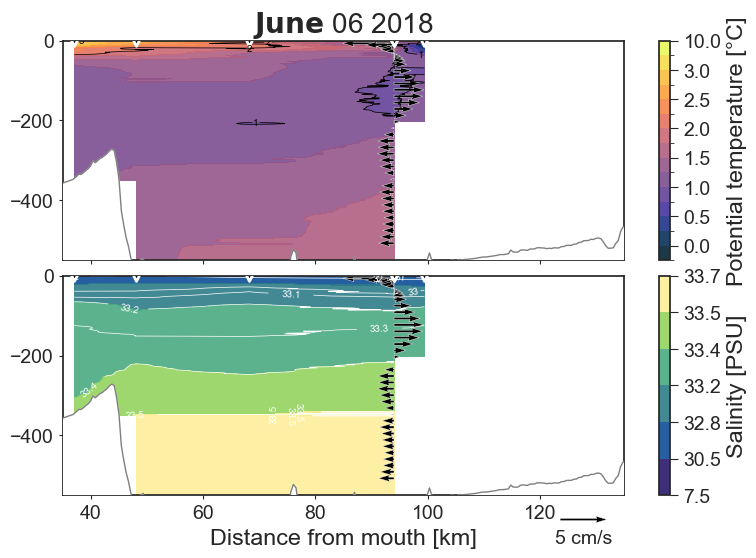

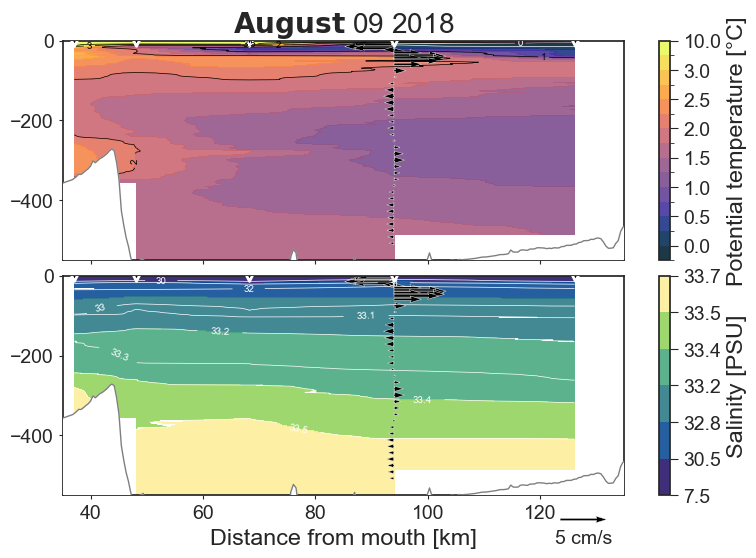

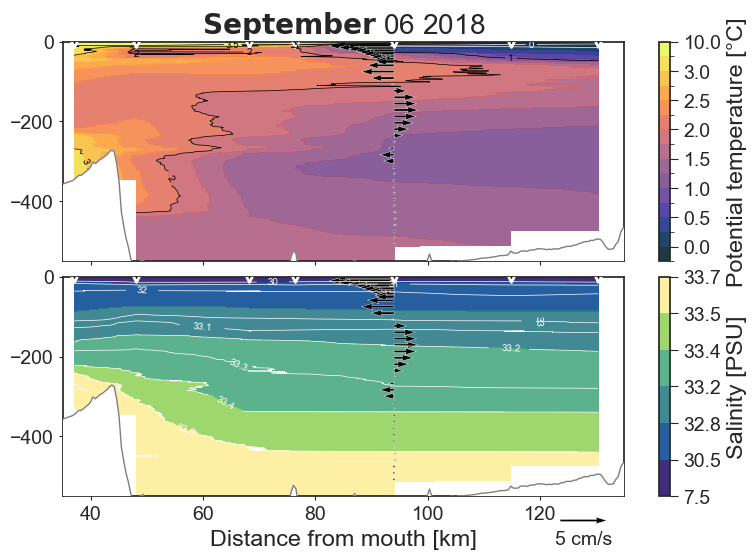

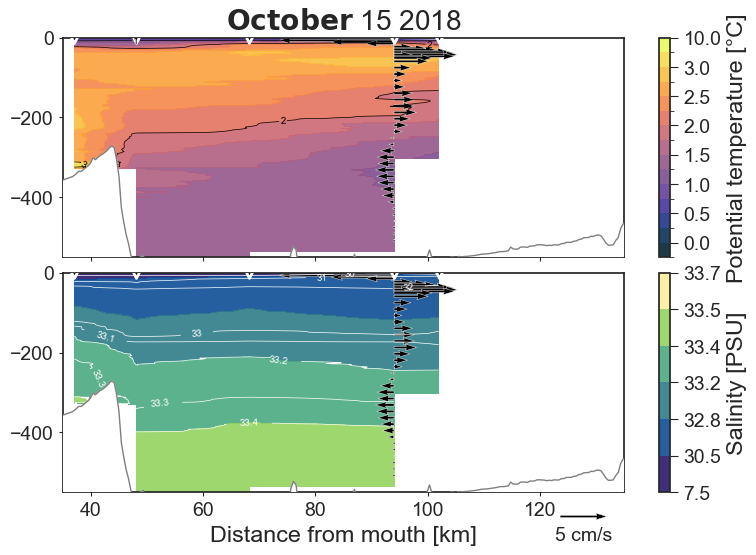

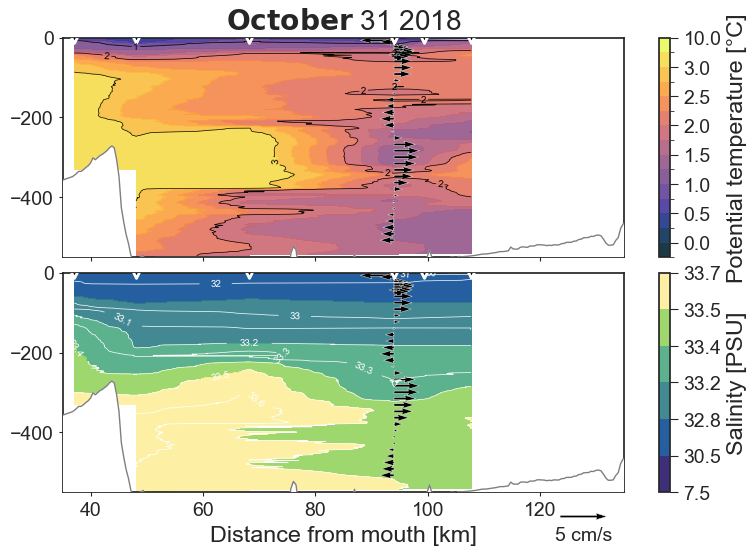

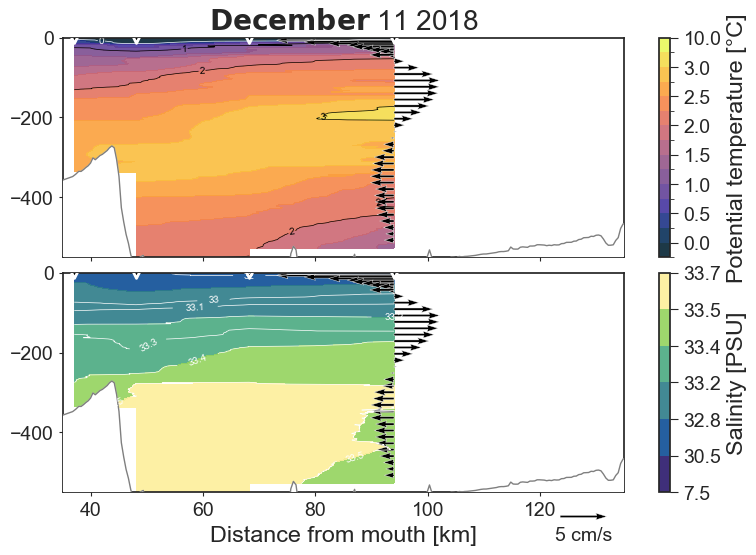

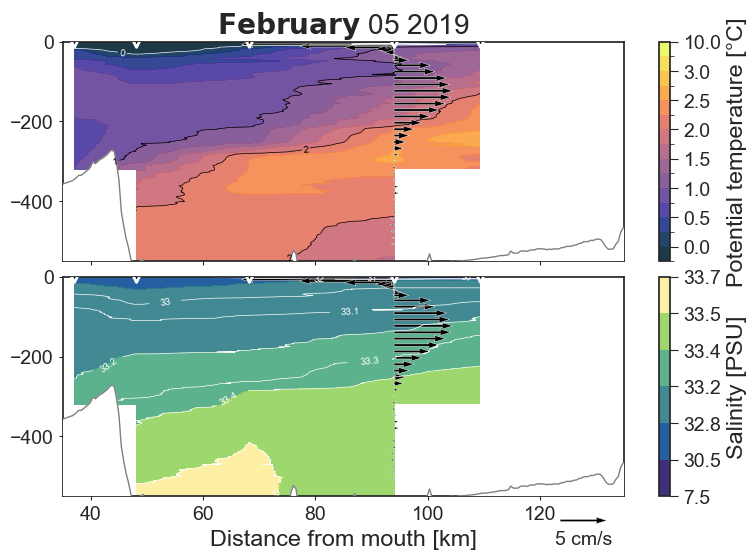

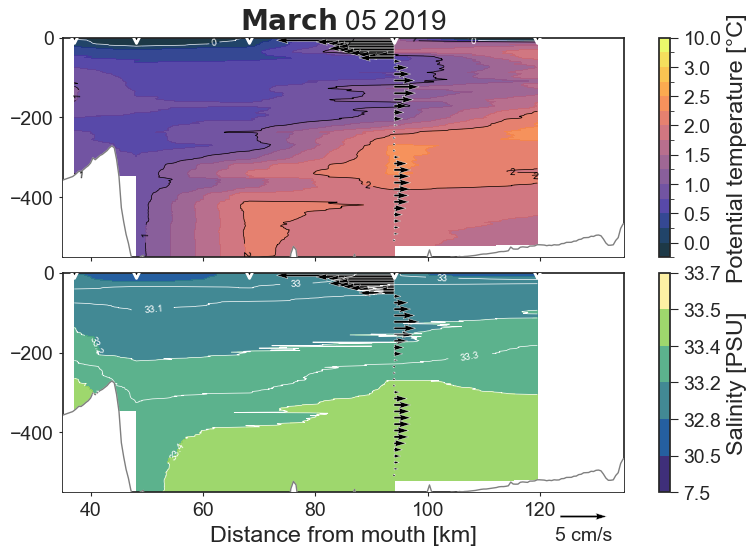

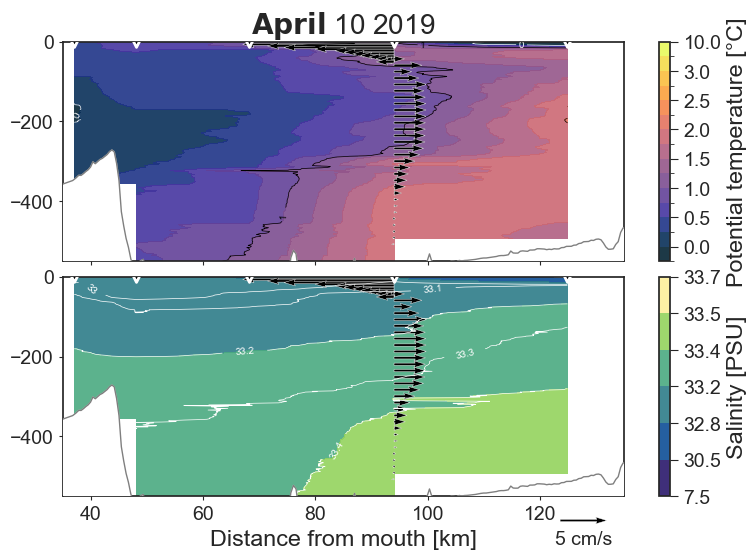

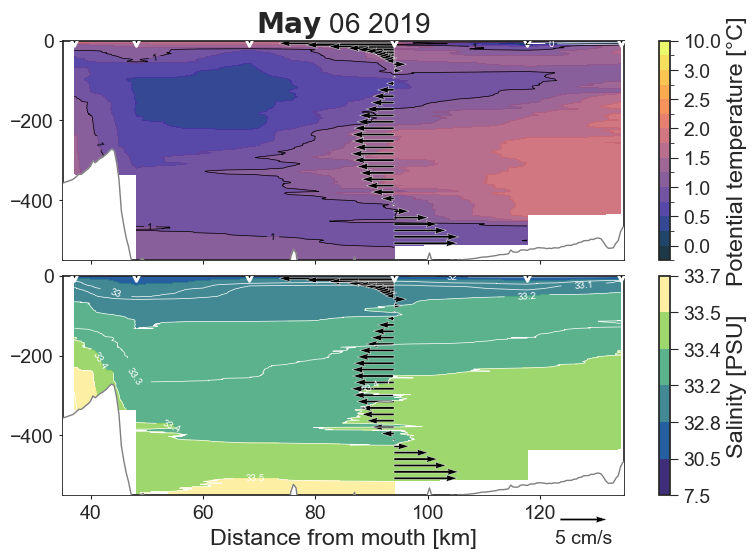

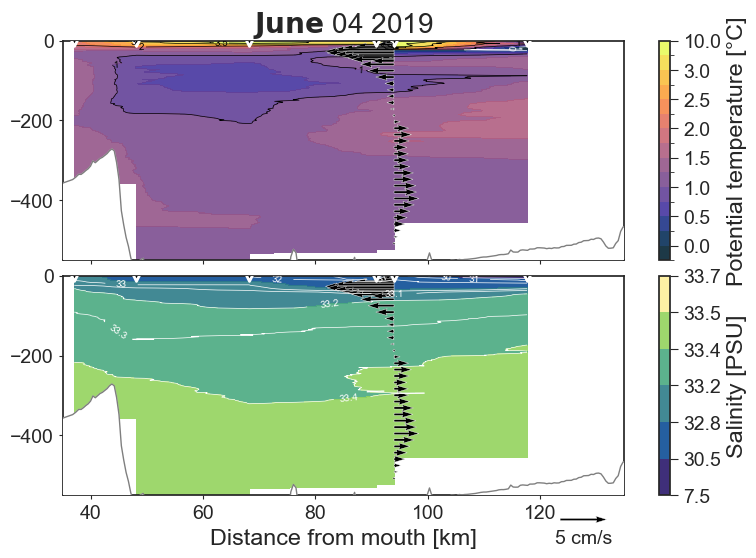

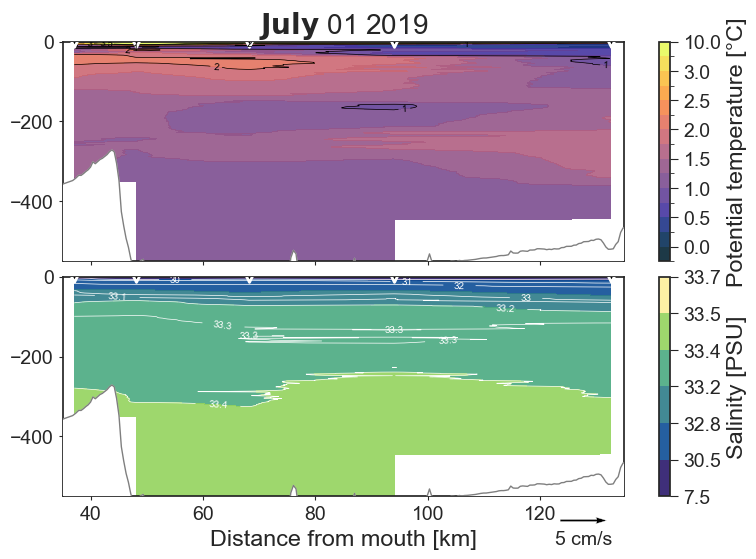

In [133]:
import matplotlib as mpl
import cmocean as cmo
from tqdm import tqdm
import cmcrameri 
plt.style.use('seaborn-ticks')


velocity_day = 7

dates = ['2018-06-06',  '2018-08-09',  '2018-09-06', '2018-10-15', '2018-10-31', 
         '2018-12-11',  '2019-02-05',  '2019-03-05', '2019-04-10', '2019-05-06','2019-06-04', '2019-07-01', ]



unique_distances = np.sort(df_all['Distance'].unique())
min_distance = unique_distances[0]


for maxz in [550]:
    plot_height = 15/7.5
    # nr_rows = len(dates[part])

    for j, date in tqdm(enumerate(dates)):
        fig, axs = plt.subplots(2, 1, sharey=True, sharex=True, figsize=(mm2inch(230), mm2inch(150)))
        

        for i, contour_var in enumerate(['Potential temperature [°C]','Salinity [PSU]',]):
            ax = axs[i]
            z_var ='Depth'
            fig1, df = plot_transect_from_big_file(date =date, variable_fill=contour_var)   # import df from file
            # levels, subplot_letter, colorscale, clabel = colors(contour_var, nrows=np.shape(axs)[0])
            xi, yi, zi = grid_data(df.Distance, df[z_var], df[contour_var], interval_x=5, interval_y=2) # grid data with interval of 5 km in x and 2 m in y

            # ... rest of the code for plotting ...
            if contour_var == 'Potential temperature [°C]':
                colorscale = mpl.colors.ListedColormap(cmo.cm.thermal(np.linspace(0, 1, 15)))
                cmap = colorscale
                bounds =[-1.8, 0,0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 2,2.25, 2.5,2.75,3, 3.5 , 10] 
                norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
                levels_l =[-1.8, 0, 1,  2,  3, 3.5, 10] 
                color_contourline = 'black'
                color_contourline = np.array(['black' if i > 0 else 'white' for i in levels_l])
            else:
                colorscale = mpl.colors.ListedColormap(['blue', 'cyan', 'green', 'red', 'purple', 'yellow'])
                cmap = colorscale
                colorscale = mpl.colors.ListedColormap(cmo.cm.haline(np.linspace(0, 1, 6)))
                bounds = [7.5, 30.5, 32.8, 33.2, 33.4,  33.5, 33.7]
                norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
                color_contourline = np.array(['black' if i >= 30.5 else 'white' for i in levels_l]) 
                short_label = 'Salinity'
                levels_l =np.sort(np.concatenate([np.arange(30, 33, 1),  np.arange(33,33.56, 0.1), np.arange(33.6, 35.1, 0.4)]))

            cfill = axs[i].contourf(xi, yi, zi,  levels=bounds, cmap=colorscale, extend=None,norm=norm, alpha=0.9)
            cline = axs[i].contour(xi, yi, zi,levels=levels_l, colors=color_contourline, linewidths=0.5  )  #     )
            q= add_velocity_vectors(axs[i], pd.to_datetime(date) - pd.Timedelta(days=1), n=2, width=4e-3, velocity_day=velocity_day, Hz='both', nmeters=4.0)
            axs[i].clabel(cline, cline.levels, inline=True, fontsize=7, zorder=16, fmt=fmt_label) # add labels to contours
            plot_stations(df, axs[i], depth=0, text=False, s=50)
            bathymetry_line(axs[i], df_bath)
            fig.colorbar(cfill, ax=axs[i], orientation='vertical', label=contour_var,)

        axs[0].set_title(r'$\bf{%s}$ %s %s' % (pd.to_datetime(date).strftime('%B'), pd.to_datetime(date).strftime('%d'), pd.to_datetime(date).strftime('%Y')))
        axs[1].set_xlabel('Distance from mouth [km]')
        for ax in axs.flat:
            ax.set_ylim([ -maxz, -0])
            ax.set_xlim([ 35, 135])
            ax.tick_params(axis='both', which='major', length=3)
        for i in range(np.shape(axs)[0]): axs[i].set_ylabel('')
        # Adjust spacing between subplots
        fig.subplots_adjust(wspace=0.06, hspace=0.07)
        axs[0].quiverkey(q, X=0.7, Y=0.07, U=50,
                    label='5 cm/s', labelpos='S', coordinates='figure')
        
        # fig.savefig(f'{figpath}/lenght_transect/Single transect/{maxz} m/{date}_CT_SA_transect_reduced_z_{maxz}_velocity_every_{velocity_day}_day.jpg', dpi=600, bbox_inches='tight')


In [92]:
help(imageio.mimsave)

Help on function mimwrite in module imageio.v2:

mimwrite(uri, ims, format=None, **kwargs)
    mimwrite(uri, ims, format=None, **kwargs)
    
    Write multiple images to the specified file.
    
    Parameters
    ----------
    uri : {str, pathlib.Path, file}
        The resource to write the images to, e.g. a filename, pathlib.Path
        or file object, see the docs for more info.
    ims : sequence of numpy arrays
        The image data. Each array must be NxM, NxMx3 or NxMx4.
    format : str
        The format to use to read the file. By default imageio selects
        the appropriate for you based on the filename and its contents.
    kwargs : ...
        Further keyword arguments are passed to the writer. See :func:`.help`
        to see what arguments are available for a particular format.



In [106]:
from PIL import Image as PilImage

gifjespath = f'{figpath}/lenght_transect/Single transect/'
images = []
file_names = sorted((fn for fn in os.listdir(gifjespath) if fn.endswith('.jpg')))

duration = 1
common_size = (1920, 1080)  # replace with the desired width and height
writer = imageio.get_writer(f'{figpath}/lenght_transect/length_transect_{duration}s.mp4', fps=1/duration)
for filename in file_names:
    print(filename)
    image = PilImage.open(gifjespath+filename)
    
    # Resize the image
    image_resized = image.resize(common_size)
    
    writer.append_data(np.array(image_resized))    
# Close the writer
writer.close()



2018-06-06_CT_SA_transect_reduced_z_600_velocity_every_3_day.jpg


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1920, 1080) to (1920, 1088) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[rawvideo @ 0x7fa7fc808c00] Stream #0: not enough frames to estimate rate; consider increasing probesize


2018-08-09_CT_SA_transect_reduced_z_600_velocity_every_3_day.jpg
2018-09-06_CT_SA_transect_reduced_z_600_velocity_every_3_day.jpg
2018-10-15_CT_SA_transect_reduced_z_600_velocity_every_3_day.jpg
2018-10-31_CT_SA_transect_reduced_z_600_velocity_every_3_day.jpg
2018-12-11_CT_SA_transect_reduced_z_600_velocity_every_3_day.jpg
2019-02-05_CT_SA_transect_reduced_z_600_velocity_every_3_day.jpg
2019-03-05_CT_SA_transect_reduced_z_600_velocity_every_3_day.jpg
2019-04-10_CT_SA_transect_reduced_z_600_velocity_every_3_day.jpg
2019-05-06_CT_SA_transect_reduced_z_600_velocity_every_3_day.jpg
2019-06-04_CT_SA_transect_reduced_z_600_velocity_every_3_day.jpg
2019-07-01_CT_SA_transect_reduced_z_600_velocity_every_3_day.jpg


In [67]:
from IPython.display import HTML
HTML('<img src="{}">'.format('/Users/annek/Library/CloudStorage/OneDrive-SharedLibraries-NIOZ/PhD Anneke Vries - General/Figures/lenght_transect/movie.gif'))

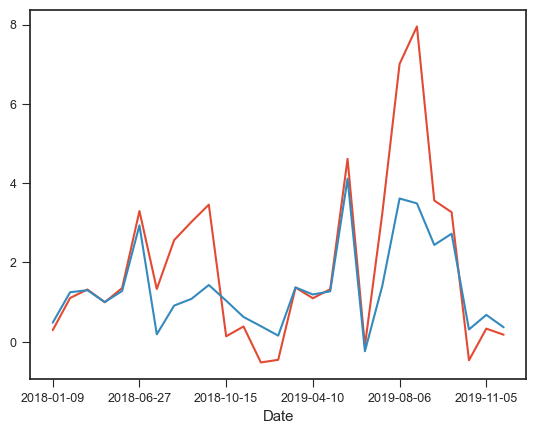

In [49]:
df_all
import matplotlib.pyplot as plt

pd.options.plotting.backend = "matplotlib"


fig, ax = plt.subplots()

# Assuming 'St' is the column for station, 'Pressure' is the pressure column, and 'Temp' is the temperature column
df_all[(df_all['St.'] == 'GF10') & (df_all['Pressure'] <= 5)].groupby('Date')['Potential temperature [°C]'].mean().plot.line(y='Potential temperature [°C]', label= "5 m", ax=ax)
df_all[(df_all['St.'] == 'GF10') & (df_all['Pressure'] <= 15)].groupby('Date')['Potential temperature [°C]'].mean().plot.line(y='Potential temperature [°C]', label="15 m", ax=ax)
plt.show()




In [52]:
import plotly.graph_objects as go

# Assuming 'St.' is the column for station, 'Pressure' is the pressure column, and 'Potential temperature [°C]' is the temperature column
df_5m = df_all[(df_all['St.'] == 'GF10') & (df_all['Pressure'] <= 5)].groupby('Date')['Potential temperature [°C]'].mean()
df_15m = df_all[(df_all['St.'] == 'GF10') & (df_all['Pressure'] <= 15)].groupby('Date')['Potential temperature [°C]'].mean()
df_50m = df_all[(df_all['St.'] == 'GF10') & (df_all['Pressure'] <= 50)].groupby('Date')['Potential temperature [°C]'].mean()
df_5m_exact = df_all[(df_all['St.'] == 'GF10') & (df_all['Pressure'] == 5)].groupby('Date')['Potential temperature [°C]'].mean()


fig = go.Figure()

fig.add_trace(go.Scatter(x=df_5m.index, y=df_5m, mode='lines', name='5 m'))
fig.add_trace(go.Scatter(x=df_5m.index, y=df_5m_exact, mode='lines', name='5 m exact'))
fig.add_trace(go.Scatter(x=df_15m.index, y=df_15m, mode='lines', name='15 m'))
fig.add_trace(go.Scatter(x=df_15m.index, y=df_50m, mode='lines', name='50 m'))

fig.show()

In [69]:
# Group the DataFrame by 'plot_date'
grouped = df_all.groupby('Plot_date')

# Initialize a list to store the indices of the maximum 'SA' for each unique 'plot_date'
max_sa_indices = []

# Iterate through the groups and find the index of the maximum 'SA' for each 'plot_date'
for date, group in grouped:
    max_sa_index = group['SA'].idxmax()
    max_sa_indices.append(max_sa_index)

# 
# make a mask where df_all is in dates
mask = df_all.Plot_date.isin(dates)
df_all.loc[max_sa_indices].set_index('Plot_date')['2019-01-01':'2019-07-01']


Pressure       timeJ  tv290C     c0S/m      flSP           par  \
Plot_date                                                                    
2019-02-05     584.0   36.574500  2.1465  2.997021  0.057557  2.378500e-05   
2019-02-27     381.0   58.778617  0.9493  2.886124  0.157190  4.648900e-05   
2019-03-05     344.0   64.504752  1.0532  2.893317  0.134770  3.306000e-05   
2019-04-10     553.0  100.668726  1.9449  2.975209  0.057763  3.797500e-05   
2019-05-06     334.0  126.450181  1.3186  2.924190  0.626480  4.465400e-05   
2019-05-14     347.0  134.570061  1.0486  2.903059  0.858850  4.740300e-07   
2019-05-21     285.0  141.625681  1.3494  2.911645  1.368500  1.656100e-05   
2019-06-04     351.0  155.465644  1.3322  2.916579  0.190420  7.444200e-05   
2019-06-14     537.0  165.579741  1.0344  2.898107  0.049454  9.816000e-05   
2019-06-19     327.0  170.567080  1.3698  2.910881  0.122990  6.697700e-05   
2019-07-01     596.0  182.515587  1.0514  2.902765  0.051169  7.967300e-05   

            sbox0Mm/Kg  seaTurbMtr    scan    depSM  ...   St.        Date  \
Plot_date                                            ...                     
2019-02-05     282.676       0.673  3980.0  577.494  ...   GF8  2019-02-05   
2019-02-27     315.750       0.616  2775.0  376.939  ...   NaN  2019-02-27   
2019-03-05     313.017       0.514  2971.0  340.364  ...   GF5  2019-03-05   
2019-04-10     278.695       0.697  3921.0  546.880  ...  GF10  2019-04-10   
2019-05-06     142.789       0.619  2796.0  330.478  ...   GF5  2019-05-06   
2019-05-14     322.497       0.623  3758.0  343.330  ...   GF3  2019-05-14   
2019-05-21     347.987       0.560  2888.0  282.028  ...   GF3  2019-05-21   
2019-06-04     334.329       3.002  3203.0  347.284  ...   GF5  2019-06-04   
2019-06-14     317.959       5.417  5368.0  531.077  ...  GF10  2019-06-14   
2019-06-19     330.413       0.784  2944.0  323.557  ...   GF3  2019-06-19   
2019-07-01     313.589       0.722  3748.0  589.343  ...   GF8  2019-07-01   

            Type      Name  YYYYMMDD   Distance  Depth         SA        CT  \
Plot_date                                                                     
2019-02-05   CTD   GF19003  20190205  68.210000 -584.0  33.668722  2.121950   
2019-02-27   CTD   GF19010  20190227  31.681445 -381.0  33.653242  0.939601   
2019-03-05   CTD   GF19011  20190305  37.045000 -344.0  33.654762  1.044987   
2019-04-10   CTD   GF19029  20190410  94.000000 -553.0  33.626213  1.923267   
2019-05-06   CTD   GF19033  20190506  37.045000 -334.0  33.770286  1.309630   
2019-05-14   CTD  HS190514  20190514  15.740000 -347.0  33.783382  1.039363   
2019-05-21   CTD  HS190521  20190521  15.740000 -285.0  33.604762  1.343954   
2019-06-04   CTD   GF19042  20190604  37.045000 -351.0  33.649053  1.323168   
2019-06-14   CTD   GF19057  20190614  94.000000 -537.0  33.628018  1.016910   
2019-06-19   CTD  HS190619  20190619  15.740000 -327.0  33.549616  1.362604   
2019-07-01   CTD   GF19060  20190701  68.210000 -596.0  33.636672  1.030674   

           Sigma_dens  
Plot_date              
2019-02-05  29.505481  
2019-02-27  28.642276  
2019-03-05  28.461539  
2019-04-10  29.345812  
2019-05-06  28.486489  
2019-05-14  28.578499  
2019-05-21  28.121679  
2019-06-04  28.468906  
2019-06-14  29.349254  
2019-06-19  28.273952  
2019-07-01  29.631482  

[11 rows x 28 columns]

In [70]:
n=1
date = '2018-06-06'
velocity_day=3
''' Adding daily mean velocity vectors, currently only for 75khz at GF10
n = plot every nth vector'''
#resample per day and choose date from dates_spring_inflow
velo_select = ds_velo_75.resample(time='1D').mean()
if velocity_day == 1:
    print('1 day')
    velo_select = velo_select.sel(time=date, z=slice(None, None, n))
else:
    bandwidth_days = np.floor(velocity_day/2)
    velo_select = velo_select.sel(time=slice(pd.to_datetime(date)-pd.to_timedelta(bandwidth_days,'days'), pd.to_datetime(date)+pd.to_timedelta(bandwidth_days,'days')), z=slice(None, None, n))
velo_select.mean('time')

<xarray.Dataset>
Dimensions:         (z: 30)
Coordinates:
  * z               (z) float64 507.3 491.3 475.3 459.3 ... 75.26 59.26 43.26
Data variables:
    SerEmmpersec    (z) float64 2.208 1.097 2.122 0.9505 ... 7.569 6.847 -1.944
    SerNmmpersec    (z) float64 2.625 -0.875 -0.5743 ... 9.625 4.806 -7.653
    SerVmmpersec    (z) float64 -5.056 -7.931 -4.878 ... -2.639 -3.792 -3.069
    SerErmmpersec   (z) float64 2.444 1.75 -1.156 -2.264 ... 1.222 -1.333 0.9946
    SerMagmmpersec  (z) float64 33.32 28.92 21.46 26.61 ... 39.93 43.14 39.42
    SerDir10thDeg   (z) float64 1.497e+03 1.709e+03 ... 1.801e+03 1.85e+03
    SerPG4          (z) float64 99.75 100.0 100.0 99.93 ... 99.5 97.15 96.58
    Alongmmpersec   (z) float64 3.255 0.4778 1.509 1.194 ... 11.48 8.349 -5.659
    Acrossmmpersec  (z) float64 -1.083 1.32 1.599 ... -4.247 -0.5162 5.507
    Along_res       (z) float64 -0.7751 -3.552 -2.822 ... 7.455 4.319 -9.689
    Across_res      (z) float64 -0.06985 2.333 2.62 ... -3.234 0.4969 6.52

In [71]:
df

Pressure       timeJ  tv290C     c0S/m     flSP         par  \
33884       1.0  113.468212  0.6811  2.826460  0.31112  300.770000   
33885       2.0  113.468235  0.6850  2.826694  0.32466  111.860000   
33886       3.0  113.468248  0.6897  2.827183  0.33123  101.750000   
33887       4.0  113.468262  0.6913  2.827461  0.33702   90.798000   
33888       5.0  113.468278  0.6984  2.828582  0.34553   86.081000   
...         ...         ...     ...       ...      ...         ...   
69185     564.0  126.562871  1.1146  2.912253  0.11496    0.000059   
69186     565.0  126.562887  1.1135  2.912160  0.12296    0.000067   
69187     566.0  126.562902  1.1130  2.912139  0.11892    0.000064   
69188     567.0  126.562918  1.1130  2.912195  0.12035    0.000050   
69189     568.0  126.562935  1.1131  2.912245  0.13477    0.000054   

       sbox0Mm/Kg  seaTurbMtr    scan    depSM  ...        Date  Type  \
33884     265.940       0.471  1371.0    0.990  ...  2019-04-23   CTD   
33885     269.554       0.427  1379.0    1.981  ...  2019-04-23   CTD   
33886     266.740       0.458  1383.0    2.971  ...  2019-04-23   CTD   
33887     282.823       0.350  1388.0    3.961  ...  2019-04-23   CTD   
33888     307.033       0.436  1394.0    4.951  ...  2019-04-23   CTD   
...           ...         ...     ...      ...  ...         ...   ...   
69185     156.174       1.285  3713.0  557.743  ...  2019-05-06   CTD   
69186     155.490       1.158  3719.0  558.731  ...  2019-05-06   CTD   
69187     155.545       1.183  3724.0  559.718  ...  2019-05-06   CTD   
69188     155.445       1.091  3729.0  560.706  ...  2019-05-06   CTD   
69189     155.621       1.271  3735.0  561.693  ...  2019-05-06   CTD   

           Name  YYYYMMDD  Distance  Depth   Plot_date         SA        CT  \
33884  HS190423  20190423     15.74   -1.0  2019-05-06  33.387458  0.689313   
33885  HS190423  20190423     15.74   -2.0  2019-05-06  33.385647  0.693227   
33886  HS190423  20190423     15.74   -3.0  2019-05-06  33.386347  0.697929   
33887  HS190423  20190423     15.74   -4.0  2019-05-06  33.387650  0.699525   
33888  HS190423  20190423     15.74   -5.0  2019-05-06  33.393977  0.706502   
...         ...       ...       ...    ...         ...        ...       ...   
69185   GF19036  20190506     94.00 -564.0  2019-05-06  33.708106  1.094829   
69186   GF19036  20190506     94.00 -565.0  2019-05-06  33.707604  1.093631   
69187   GF19036  20190506     94.00 -566.0  2019-05-06  33.707302  1.093132   
69188   GF19036  20190506     94.00 -567.0  2019-05-06  33.707504  1.093131   
69189   GF19036  20190506     94.00 -568.0  2019-05-06  33.707403  1.093131   

      Sigma_dens  
33884  26.648174  
33885  26.651254  
33886  26.656298  
33887  26.662005  
33888  26.671418  
...          ...  
69185  29.533182  
69186  29.537563  
69187  29.542047  
69188  29.546890  
69189  29.551493  

[3356 rows x 29 columns]

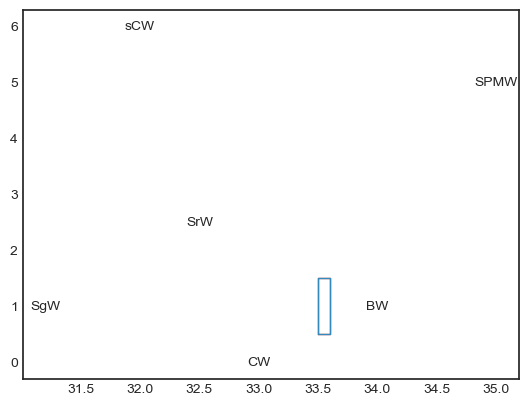

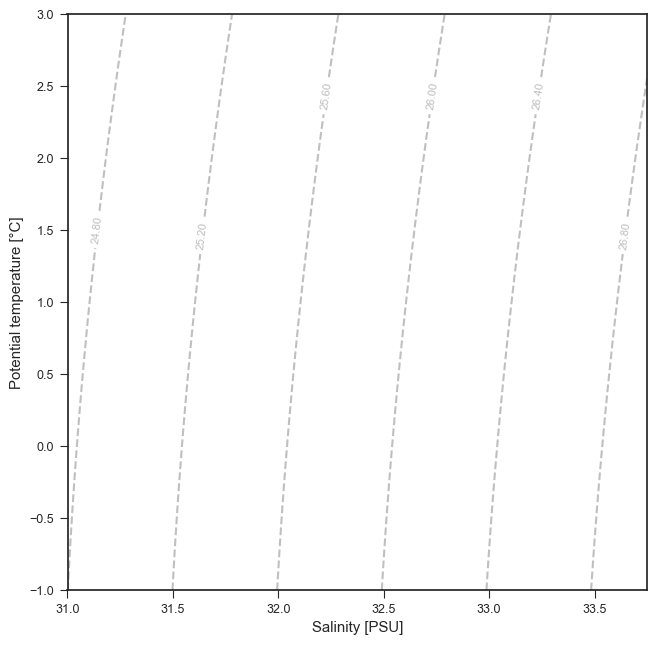

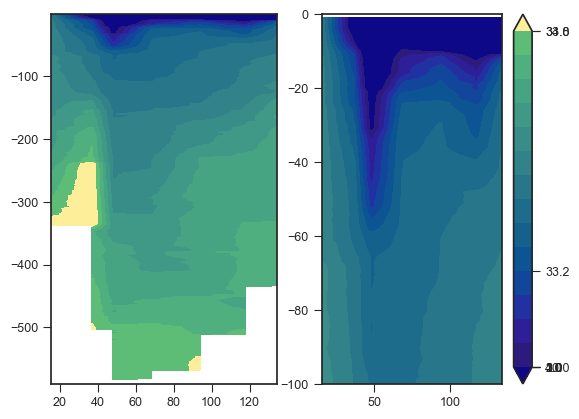

array([33.  , 33.05, 33.1 , 33.15, 33.2 , 33.25, 33.3 , 33.35, 33.4 ,
       33.45, 33.5 , 33.55, 33.6 , 33.65, 33.7 ])

In [72]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cmocean as cmo

data1 = np.random.rand(100,1) *35
data2 = np.random.rand(100,1) *1 +33
# choose random data from data1 and data2
data = np.random.choice(np.squeeze(np.concatenate((data1, data2), axis=0)), size =(10,10))

levels = np.arange(33.2,33.75,0.05)
colorscale = "cmo.haline"
clabel= "Salinity [g/kg]"


colors1 = plt.cm.plasma(np.linspace(0, 1, 256))
colors2 = cmo.cm.haline(np.linspace(0.0, 1, 256))
all_colors = np.vstack((colors1, colors2))
cmap_sal = mcolors.LinearSegmentedColormap.from_list(
    'cmap_sal', all_colors)

vcenter = 33
vmax = 35
vmin = 0
# make the norm:  Note the center is offset so that the land has more
# dynamic range:
divnorm = mcolors.TwoSlopeNorm(vmin=30, vcenter=33., vmax=34)

fig, ax = plt.subplots(1,2)
levels = np.arange(33,33.7,0.05)
cfill = ax[0].contourf(xi, yi, zi,   cmap=cmap_sal, extend='both', norm=divnorm,levels=levels)    # this is the plotiting of theo contour fill
cfill = ax[1].contourf(xi, yi, zi,   cmap=cmap_sal, extend='both', norm=divnorm,levels=levels)

ax[1].set_ylim([-100, 0])

# Simple geographic plot, set aspect ratio because distance between lines of
# longitude depends on latitude.
# cb = fig.colorbar(pcm, shrink=0.8)
cb = plt.colorbar(cfill)
# cb.set_ticks(np.concatenate([np.linspace(vmin, vcenter, 4), np.linspace(vcenter, vmax, 4)]))

levels2 = (np.unique(np.concatenate([np.linspace(vmin, vcenter, 4), np.linspace(vcenter, vmax, 5)])))
cb.set_ticks([1, 2, 3, 4, 30,33.2,33.8, 34])
plt.show()
# remove duplicates from array
levels

In [73]:
df[contour_var] 
# get percentiles of df[contour_var]
df[contour_var].quantile([0.01, 0.1, 0.25, 0.5, 0.75, 0.9])
df[contour_var].sort_values().unique()
print(df_all[df_all.Depth>-50].SA.quantile(np.linspace(0,1,21))
)
df_all[df_all.Depth>-50].SA.hist()


0.00     4.610170
0.05    28.090068
0.10    30.064479
0.15    30.763601
0.20    31.199467
0.25    31.530590
0.30    31.772699
0.35    31.955058
0.40    32.099903
0.45    32.235535
0.50    32.369314
0.55    32.538077
0.60    32.672368
0.65    32.809980
0.70    32.932612
0.75    33.038340
0.80    33.109598
0.85    33.183743
0.90    33.260239
0.95    33.327186
1.00    33.444605
Name: SA, dtype: float64


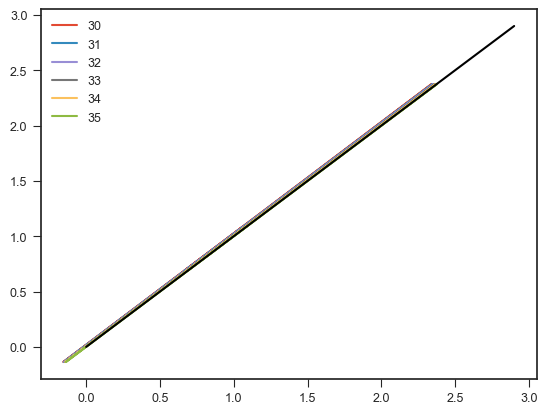

In [74]:

for sal in np.arange(30, 36, 1):
    plt.plot(gsw.pt_from_CT(sal, df.CT), df.CT, label=sal)
plt.legend()
# set a line to show the 1:1 relationship
x = np.arange(0, 3, 0.1)
plt.plot(x, x, 'k')
plt.show()
x = np.arange(30, 34, 0.1)
plt.plot(x, x, 'k')
for pres in [0, 100, 200, 300, 400, 500, 600,10000]:
    plt.scatter(gsw.SP_from_SA(df.SA.values, pres, lon=lon,lat=lat), df.SA, label=pres)
plt.legend()

In [75]:
# make a scatter plot for df.CT vs df.Depth
fig, ax = plt.subplots(1,1)
_, df = plot_transect_from_big_file(date =dates[0], variable_fill='SA')   # import df from file
sc= ax.scatter(df.SA, df.Depth, s=1, c=df.SA, cmap='viridis')
ax.set_ylim([-620, 0])
ax.set_xlabel('Conservative Temperature [$^\circ$C]')

secax = ax.secondary_xaxis('top', functions=(SAtoPS, PStoSA))
secax.set_xlabel('Practical Salinity')

# # add ax for colorbar
# cbar = fig.colorbar(sc)
# cbar.set_label('Absolute Salinity')

# cax2 = cax.twinx()


# cax2.set_yticks(ticks2)
# # cax2.set_yticklabels(1./iticks)
# cax2.set_ylabel("Practical Salinity")
# cbar.ax.set_aspect('auto')

# plt.show()


# # generate random data
# x = np.random.randint(0,200,(10,10))
# plt.pcolormesh(x)

# create the colorbar
# the aspect of the colorbar is set to 'equal', we have to set it to 'auto',
# otherwise twinx() will do weird stuff.
cbar = plt.colorbar(sc)
ticks = cbar.get_ticks()
ticks2 = SAtoPS(ticks)
pos = cbar.ax.get_position()
cbar.ax.set_aspect('auto')
cbar.ax.set_yticks(ticks)

# create a second axes instance and set the limits you need
ax2 = cbar.ax.twinx()
ax2.set_ylim([min(ticks2), max(ticks2)])
ax2.set_yticks(ticks2)

# resize the colorbar (otherwise it overlays the plot)
pos.x0 +=0.05
cbar.ax.set_position(pos)
ax2.set_position(pos)
ax2.set_ylabel("Practical Salinity")
cbar.ax.set_ylabel("Absolute Salinity")

plt.show()

ValueError: ('Lengths must match to compare', (76033,), (8,))

In [76]:
cbar.get_ticks()

array([  0.,  25.,  50.,  75., 100.])

In [77]:
#resample per day and choose date from dates_spring_inflow
velo_select = ds_velo_75.resample(time='1D').mean().sel(time=date_spring_inflow[-1])
ax.quiver(np.repeat(94, len(velo_select.z)), velo_select.z*-1, velo_select.Alongmmpersec, 0,)


# Compare interpolation contourf

In [78]:
fig1, df = plot_transect_from_big_file(date ='2018-06-06', variable_fill=contour_var)   # import df from file

fig, ax = plt.subplots(2,1, figsize=(5,5), sharex=True, sharey=True)
ax[0].scatter(df.Distance, df[z_var], s=0.1, c='black', zorder=2, label= 'Data points')
xi, yi, zi = grid_data(df.Distance, df[z_var], df[contour_var], interval_x=0.5, interval_y=2, interpolate=True) # grid data with interval of 5 km in x and 2 m in y
ax[0].contourf(xi, yi, zi ,  levels=levels, cmap=colorscale, extend='both')    # this is the plotiting of theo contour fill
ax[0].set_title(f'1 km grid - {df.Date.iloc[0]}')
# box around legend, make data points visible
ax[0].legend(frameon=True, fancybox=True, framealpha=1, markerscale=10, loc = 'lower left') 
plot_stations(df, ax[0],depth=0, text=False)

xi, yi, zi = grid_data(df.Distance, df[z_var], df[contour_var], interpolate=False) # grid data with interval of 5 km in x and 2 m in y
ax[1].scatter(df.Distance, df[z_var], s=0.1, c='black', zorder=2)
ax[1].contourf(xi, yi, zi ,  levels=levels, cmap=colorscale, extend='both')    # this is the plotiting of theo contour fill
ax[1].set_title('no grid')

# xlim 35 100, y lim 0, -600
ax[0].set_ylim([-600, 10])
ax[0].set_xlim([35, 100])

# save in folder figpath "Method" as png
# fig.savefig(f'{figpath}/Method/contourf_grid_interpolation_comparison.png', dpi=300, bbox_inches='tight')


(35.0, 100.0)

Import data

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import plotly.express as px
from bathymetry_along_fjord import df_bath
import gsw
import xarray as xr

path_parent = Path.cwd().parent.parent
path_intermediate_files = Path.cwd().parent.joinpath("intermediate_files")


df_all = pd.read_csv(f"{path_intermediate_files}/monthly_all_years_all_stations.csv")

df_all.set_index(['Pressure [dbar]', 'timeJ', 'Distance']).drop_duplicates().to_xarray()



: 